### This code provides: 

    1) Downloading the raw TNG100 SIM data at z=0, 
    2) Choosing only central galaxies 
    3) Removing the 14 galaxies with NaNs in their _dmo values
    4) Calculating the percentage of 0s in each column (feature) and removing the features with mostly 0 entries
    5) Comparing the histograms of features vs their _dmo version 
    6) Looking at correlations of the raw dataset
    7) Normalizing the dataset by dividing all mass features by halo mass, galaxy size by halo size
    8) Removing the not needed features, as well as features used for normalization from the Normalized Dataset
    9) Saving the Raw dataset 
    10) Saving the Normalized Dataset, as well as its version after removing the 23 non-physical galaxies
    11) Looking at correlations of the 0D (dimensionless/normalized) dataset
    12) Plotting mass-size-spin relation for Raw Dataset
    13) Plotting mass-size-spin relation for 0D Dataset

In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns
from scipy import stats

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

In [3]:
# read the dark matter-matched SIM dataset of 9/2/23 downloaded from Dropbox 

# It is called tng100-matchLHalo_v2.h5 because it used the LHalo matching algorithm, and v2 because Ari fixed
# any matching problems in the previous dataset. The histogram of spin_dmo for centrals looks fine.  
# Still there is ~5% of centrals in the sim who match to satellites in the dmo where Ari set the spin to 0.0.
# We can either not include those in analysis, or think harder about wha to do with them.

# Note: Cleaning the data is now going to be much harder then it was for the SAM. 
# That is because only 82% of galaxies have a dark matter only match, and some matches may be better than others. 
# So when is something an outlier? I don't know:)
# The catalog should have a repeated entry with a dmo for the matching property in the dark matter only run.
# This only applies to properties that make sense in both catalogs. Our main interest in the dark matter only catalog 
# is the GroupSpin_dmo because the GroupSpin from the hydro catalog includes the spin of the stars.  
# I think GroupSpin shouldn't be used in ML, I include it to compare to GroupSpin_dmo for our understanding. 
# It is not clear that any other dmo features are useful as they should all have high correlation with the hydro total mass, and if they don't then I worry about the match.
# Subhalo and Group are like Galprop and Haloprop for the SAM
df=pd.read_hdf('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG_Data_SAM_and_SIM/data/tng100-matchLHalo_v2.h5') 

In [4]:
df

,SubhaloBHMass,SubhaloBHMdot,SubhaloGasMetallicity,SubhaloMass,SubhaloSFRinRad,SubhaloStarMetallicity,SubhaloVelDisp,SubhaloVmax,SubhaloVmaxRad,SubhaloRgas,SubhaloRstar,SubhaloMgas,SubhaloMstar,SubhaloJx,SubhaloJy,SubhaloJz,SubhaloCentral,GroupNsubs,GroupBHMass,GroupMass,Group_M_Crit200,Group_M_TopHat200,Group_R_Crit200,Group_R_TopHat200,SubhaloMHI,SubhaloMH2,SubhaloMass_dmo,SubhaloVelDisp_dmo,SubhaloVmax_dmo,SubhaloVmaxRad_dmo,SubhaloJx_dmo,SubhaloJy_dmo,SubhaloJz_dmo,SubhaloCentral_dmo,GroupNsubs_dmo,GroupMass_dmo,Group_M_Crit200_dmo,Group_M_TopHat200_dmo,Group_R_Crit200_dmo,Group_R_TopHat200_dmo,Group_V_TopHat200,Group_V_Crit200,GroupSpin,Group_V_TopHat200_dmo,Group_V_Crit200_dmo,GroupSpin_dmo
0,9.956542e+09,3.980102e-04,0.007718,3.903116e+14,0.195825,0.028622,603.875061,999.385132,465.664864,891.066223,67.312584,1.236131e+13,3.143714e+12,25565.121094,-5412.154297,-34774.015625,1,17185,3.604464e+10,5.522448e+14,3.625763e+14,4.435949e+14,1465.437988,1959.448853,1.153075e+10,1.105946e+10,4.086920e+14,635.132324,981.919495,519.949219,20518.474609,1294.048096,-41196.515625,1.0,24681.0,5.835940e+14,3.505198e+14,4.375438e+14,1449.026489,1950.562622,986.644165,1031.454834,0.015910,982.121096,1019.887621,0.016995
1,1.782920e+09,2.301299e-04,0.008247,5.208271e+13,0.088085,0.021265,333.893250,514.775879,534.375928,523.474487,24.165314,3.277196e+12,5.267424e+11,18177.472656,-18764.296875,20260.164062,0,17185,3.604464e+10,5.522448e+14,3.625763e+14,4.435949e+14,1465.437988,1959.448853,1.135352e+10,4.910214e+09,4.676955e+13,357.544403,542.061462,222.147768,14759.326172,-14425.914062,15648.297852,0.0,24681.0,5.835940e+14,3.505198e+14,4.375438e+14,1449.026489,1950.562622,986.644165,1031.454834,0.000000,982.121096,1019.887621,0.000000
2,2.521123e+09,1.053986e-03,0.011213,1.098658e+13,5.294215,0.025407,297.577271,461.641266,100.825992,70.518997,21.284046,1.219379e+11,5.263741e+11,3511.812744,9133.740234,784.299500,0,17185,3.604464e+10,5.522448e+14,3.625763e+14,4.435949e+14,1465.437988,1959.448853,5.529453e+10,3.228322e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,986.644165,1031.454834,0.000000,NaN,NaN,0.000000
3,4.888925e+08,5.128397e-05,0.020788,4.817231e+12,2.142880,0.023964,159.561844,291.936554,3.278761,165.368149,9.275959,1.175942e+07,4.426219e+10,2858.906250,-1565.697754,-3908.470215,0,17185,3.604464e+10,5.522448e+14,3.625763e+14,4.435949e+14,1465.437988,1959.448853,2.222854e+10,1.196808e+10,5.371537e+12,164.704544,276.304749,114.007625,3174.506104,-265.736572,-3417.126465,0.0,24681.0,5.835940e+14,3.505198e+14,4.375438e+14,1449.026489,1950.562622,986.644165,1031.454834,0.000000,982.121096,1019.887621,0.000000
4,7.420399e+08,4.726646e-05,0.013132,4.621686e+12,0.283784,0.020044,168.744232,294.432983,59.798929,81.432083,12.771088,4.665965e+10,1.159663e+11,1614.306519,1771.974243,-3377.773193,0,17185,3.604464e+10,5.522448e+14,3.625763e+14,4.435949e+14,1465.437988,1959.448853,3.209130e+10,8.777918e+09,5.380579e+12,175.896332,303.004944,93.127500,1387.800903,1714.996460,-3271.587158,0.0,24681.0,5.835940e+14,3.505198e+14,4.375438e+14,1449.026489,1950.562622,986.644165,1031.454834,0.000000,982.121096,1019.887621,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770944,0.000000e+00,0.000000e+00,0.000000,2.595973e+10,0.000000,0.009717,41.457130,84.234489,3.764390,0.000000,2.723686,0.000000e+00,1.016745e+09,-37.572643,-1.598404,-3.702922,1,2,0.000000e+00,3.105587e+10,2.695313e+10,3.139350e+10,61.616226,81.050018,NaN,NaN,2.815763e+10,40.857986,81.018661,7.003914,29.665665,36.846657,-0.364331,0.0,2680.0,8.512075e+13,7.870825e+13,8.868756e+13,880.758118,1145.776001,40.811024,43.370182,0.008078,576.920166,619.891977,0.000051
776030,0.000000e+00,0.000000e+00,0.000000,2.511365e+10,0.000000,0.008567,35.709969,71.033455,6.213138,0.000000,3.587614,0.000000e+00,8.242086e+08,-6.384537,28.086805,4.2

In [5]:
df.shape

(21447, 46)

In [6]:
df['SubhaloCentral'].describe()

count    21447.000000
mean         0.604560
std          0.488956
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: SubhaloCentral, dtype: float64

In [7]:
df['SubhaloCentral'].value_counts()

1    12966
0     8481
Name: SubhaloCentral, dtype: int64

In [8]:
df['SubhaloCentral_dmo'].describe()

count    18625.000000
mean         0.687141
std          0.463670
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: SubhaloCentral_dmo, dtype: float64

In [9]:
df['SubhaloCentral_dmo'].value_counts()

1.0    12798
0.0     5827
Name: SubhaloCentral_dmo, dtype: int64

1279800/12966=98.7
About ~2% of central galaxies in SIM are matched to satellites in DMO

## Choose Central Galaxies only - 12,966 galaxies are centrals


In [10]:
# choose only central galaxies only; 12,966 galaxies are centrals
df = df[df.loc[:, 'SubhaloCentral'] == True]

## Why NaNs in Group_R_TopHat200_dmo_0D and Group_R_Crit200_dmo_0D??

In [11]:
df['Group_R_TopHat200'].describe()

count    12966.000000
mean       202.607086
std        112.566826
min         68.206345
25%        144.019726
50%        169.849091
75%        220.179447
max       2021.319336
Name: Group_R_TopHat200, dtype: float64

In [12]:
df['Group_R_TopHat200_dmo'].describe()

count    12952.000000
mean       219.708515
std        156.844590
min         76.661774
25%        147.923870
50%        174.691109
75%        228.356590
max       1986.413452
Name: Group_R_TopHat200_dmo, dtype: float64

In [13]:
df['Group_R_TopHat200_dmo'].replace(0, np.nan).isnull().sum()

14

In [14]:
df['Group_M_TopHat200'].replace(0, np.nan).isnull().sum()

0

In [15]:
df['Group_M_TopHat200_dmo'].replace(0, np.nan).isnull().sum()

14

In [16]:
df['Group_V_TopHat200'].replace(0, np.nan).isnull().sum()

0

In [17]:
df['Group_V_TopHat200_dmo'].replace(0, np.nan).isnull().sum()

14

In [18]:
df['Group_R_Crit200'].replace(0, np.nan).isnull().sum()

0

In [19]:
df['Group_R_Crit200_dmo'].replace(0, np.nan).isnull().sum()

14

In [20]:
df['Group_M_Crit200'].replace(0, np.nan).isnull().sum()

0

In [21]:
df['Group_M_Crit200_dmo'].replace(0, np.nan).isnull().sum()

14

In [22]:
df['Group_V_Crit200'].replace(0, np.nan).isnull().sum()

0

In [23]:
df['Group_V_Crit200_dmo'].replace(0, np.nan).isnull().sum()

14

In [24]:
df['SubhaloMass'].replace(0, np.nan).isnull().sum()

0

In [25]:
df['SubhaloMass_dmo'].replace(0, np.nan).isnull().sum()

14

In [26]:
df['GroupMass'].replace(0, np.nan).isnull().sum()

0

In [27]:
df['GroupMass_dmo'].replace(0, np.nan).isnull().sum()

14

In [28]:
df['GroupSpin_dmo'].replace(0, np.nan).isnull().sum()

14

In [29]:
1400/12966

0.10797470306956655

Note: No NaNs in Group_R_TopHat200, Group_M_TopHat200 and Group_M_TopHat200;

but 14 NaNs in Group_R_TopHat200_dmo, Group_M_TopHat200_dmo and Group_V_TopHat200_dmo (out of 12,966 total galaxies).

Similarly, no NaNs in 'Group_R,M,V_Crit200', but 14 NaNs in 'Group_R, M, V_Crit200_dmo'.

Similarly, no NaNs in 'SubhaloMass' and 'GroupMass', but 14 NaNs in 'SubhaloMass_dmo' and 'GroupMass_dmo'.

GroupSpin has no NaNs, GroupSpin_dmo has 14 NaNs.


In [30]:
# Such an object with NaNs in _dmo values has strange 0 values for many other fields like Mgas, Rgas
# Mstar is log10Mstar=8 (small mass)
df.loc[813831, :]

SubhaloBHMass             0.000000e+00
SubhaloBHMdot             0.000000e+00
SubhaloGasMetallicity     0.000000e+00
SubhaloMass               1.651273e+10
SubhaloSFRinRad           0.000000e+00
SubhaloStarMetallicity    9.282972e-03
SubhaloVelDisp            3.638013e+01
SubhaloVmax               7.169190e+01
SubhaloVmaxRad            5.003431e+00
SubhaloRgas               0.000000e+00
SubhaloRstar              3.394639e+00
SubhaloMgas               0.000000e+00
SubhaloMstar              9.078227e+08
SubhaloJx                 1.009063e+00
SubhaloJy                -2.103759e+01
SubhaloJz                -1.109929e+01
SubhaloCentral            1.000000e+00
GroupNsubs                1.000000e+00
GroupBHMass               0.000000e+00
GroupMass                 1.735872e+10
Group_M_Crit200           1.783246e+10
Group_M_TopHat200         1.870979e+10
Group_R_Crit200           5.369353e+01
Group_R_TopHat200         6.820634e+01
SubhaloMHI                         NaN
SubhaloMH2               

In [31]:
(np.log10(df['SubhaloMstar'])).min()

8.903256

In [32]:
(np.log10(df['SubhaloMstar'])).max()

12.497443

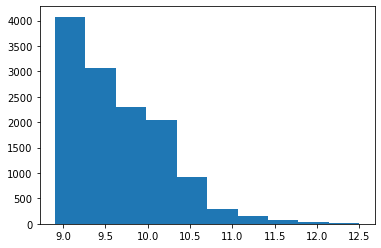

In [33]:
plt.hist(np.log10(df['SubhaloMstar']))
plt.show()

In [34]:
# 1,223 galaxies with log10Mstar<9
df[np.log10(df.loc[:, 'SubhaloMstar'])<9]

,SubhaloBHMass,SubhaloBHMdot,SubhaloGasMetallicity,SubhaloMass,SubhaloSFRinRad,SubhaloStarMetallicity,SubhaloVelDisp,SubhaloVmax,SubhaloVmaxRad,SubhaloRgas,SubhaloRstar,SubhaloMgas,SubhaloMstar,SubhaloJx,SubhaloJy,SubhaloJz,SubhaloCentral,GroupNsubs,GroupBHMass,GroupMass,Group_M_Crit200,Group_M_TopHat200,Group_R_Crit200,Group_R_TopHat200,SubhaloMHI,SubhaloMH2,SubhaloMass_dmo,SubhaloVelDisp_dmo,SubhaloVmax_dmo,SubhaloVmaxRad_dmo,SubhaloJx_dmo,SubhaloJy_dmo,SubhaloJz_dmo,SubhaloCentral_dmo,GroupNsubs_dmo,GroupMass_dmo,Group_M_Crit200_dmo,Group_M_TopHat200_dmo,Group_R_Crit200_dmo,Group_R_TopHat200_dmo,Group_V_TopHat200,Group_V_Crit200,GroupSpin,Group_V_TopHat200_dmo,Group_V_Crit200_dmo,GroupSpin_dmo
536698,1.950218e+06,2.431757e-05,0.006286,3.389692e+11,0.265222,0.005974,59.720810,98.096748,19.053717,86.873512,3.793778,4.305528e+09,848658176.0,-604.792969,-26.877411,988.674438,1,38,37868720.0,7.490017e+11,3.105082e+11,3.734693e+11,139.162003,185.028183,NaN,NaN,3.021321e+11,63.736752,105.162804,32.964782,-744.394043,302.593872,961.942139,0.0,57.0,8.175598e+11,2.973766e+11,3.975816e+11,137.170944,188.926178,93.162857,97.951355,0.047555,95.126457,96.550959,0.049315
552034,1.553263e+06,5.387617e-06,0.009320,1.715525e+11,0.305482,0.009440,52.141312,100.433922,13.277858,18.306160,2.712046,4.926097e+09,992023168.0,474.646912,117.813217,407.880524,1,39,5052499.5,5.986376e+11,1.632951e+11,2.108711e+11,112.329346,152.924103,NaN,NaN,1.173178e+11,56.403404,93.553909,24.299226,364.462952,-24.497192,121.281464,0.0,96.0,1.258222e+12,4.766599e+11,5.670558e+11,160.533905,212.660568,77.002495,79.063171,0.038240,107.078837,112.993941,0.011952
563831,4.040788e+06,2.400687e-04,0.005207,2.844515e+11,0.253336,0.006761,54.237003,97.630959,20.056412,79.501945,4.324774,6.398062e+09,909437440.0,-696.863708,-17.881002,348.029236,1,28,6780050.0,4.998077e+11,2.225876e+11,4.194439e+11,124.549164,192.327927,NaN,NaN,2.938143e+11,53.632023,90.574104,32.207711,-806.509949,47.859192,416.557312,1.0,41.0,5.276232e+11,2.194829e+11,3.961925e+11,123.967354,188.701019,96.838936,87.662590,0.029581,95.016760,87.253115,0.035849
568208,8.434052e+06,2.744833e-04,0.019359,2.755694e+11,0.256558,0.015562,56.402298,105.777428,0.416853,64.918106,0.547738,8.471021e+07,868222528.0,1402.758423,261.953857,-153.420197,1,28,9931785.0,4.588436e+11,2.341344e+11,2.753395e+11,126.665222,167.143097,NaN,NaN,3.081147e+11,57.244984,103.743484,30.592604,1431.711792,744.343079,-404.714325,1.0,36.0,5.096583e+11,2.342606e+11,2.816956e+11,126.692154,168.424408,84.163589,89.153442,0.072143,84.805058,89.167992,0.082359
578285,2.776275e+06,2.984067e-05,0.008028,2.585453e+11,0.083652,0.008199,50.086853,83.228088,16.572490,97.096657,2.402233,5.152145e+09,932160448.0,1885.592773,1455.162354,-1033.479980,1,39,3949104.5,4.014089e+11,1.884142e+11,2.407119e+11,117.818848,159.828354,NaN,NaN,2.439845e+11,49.135269,75.125069,88.176229,1722.404663,1428.381348,-910.533325,1.0,46.0,4.115753e+11,1.782010e+11,2.389905e+11,115.649200,159.444962,80.474083,82.924652,0.142738,80.282171,81.398792,0.133448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768905,0.000000e+00,0.000000e+00,0.000000,3.258072e+10,0.000000,0.008719,43.452881,84.892281,5.660329,0.000000,3.876068,0.000000e+00,914979008.0,-40.912228,-5.362635,-37.783226,1,1,0.0,3.392446e+10,3.431310e+10,3.724376e+10,66.783394,85.799103,NaN,NaN,4.753731e+10,43.530922,86.309448,9.646123,-36.409180,-52.449692,-1.542463,1.0,2.0,5.098883e+10,4.850033e+10,5.377562e+10,74.950134,96.976433,43.203568,47.003479,0.010672,48.830799,52.749743,0.009537
776030,0.000000e+00,0.000000e+00,0.000000,2.511365e+10,0.000000,0.008567,35.709969,71.033455,6.213138,0.000000,3.587614,0.000000e+00,824208576.0,-6.384537,28.086805,4.240551,1,2,0.0,3.231482e+10,2.759283e+10,3.122053e+10,62.102222,80.902184,NaN,NaN,1.711275e+10,35.376125,66.925598,7.898712,3.47

In [35]:
df[df.loc[:, 'GroupSpin_dmo'].isna()].shape

(14, 46)

In [36]:
df_wNaNs = df[df.loc[:, 'GroupSpin_dmo'].isna()]

In [37]:
# drop the 14 rows that have NaNs in 'GroupSin_dmo'
df = df.dropna(axis=0,subset= ['GroupSpin_dmo'])

# Can also use the line below to get the same dataset
# df.dropna(axis=0,subset= ['GroupSpin_dmo'], inplace=True)

In [38]:
df

,SubhaloBHMass,SubhaloBHMdot,SubhaloGasMetallicity,SubhaloMass,SubhaloSFRinRad,SubhaloStarMetallicity,SubhaloVelDisp,SubhaloVmax,SubhaloVmaxRad,SubhaloRgas,SubhaloRstar,SubhaloMgas,SubhaloMstar,SubhaloJx,SubhaloJy,SubhaloJz,SubhaloCentral,GroupNsubs,GroupBHMass,GroupMass,Group_M_Crit200,Group_M_TopHat200,Group_R_Crit200,Group_R_TopHat200,SubhaloMHI,SubhaloMH2,SubhaloMass_dmo,SubhaloVelDisp_dmo,SubhaloVmax_dmo,SubhaloVmaxRad_dmo,SubhaloJx_dmo,SubhaloJy_dmo,SubhaloJz_dmo,SubhaloCentral_dmo,GroupNsubs_dmo,GroupMass_dmo,Group_M_Crit200_dmo,Group_M_TopHat200_dmo,Group_R_Crit200_dmo,Group_R_TopHat200_dmo,Group_V_TopHat200,Group_V_Crit200,GroupSpin,Group_V_TopHat200_dmo,Group_V_Crit200_dmo,GroupSpin_dmo
0,9.956542e+09,3.980102e-04,0.007718,3.903116e+14,0.195825,0.028622,603.875061,999.385132,465.664864,891.066223,67.312584,1.236131e+13,3.143714e+12,25565.121094,-5412.154297,-34774.015625,1,17185,3.604464e+10,5.522448e+14,3.625763e+14,4.435949e+14,1465.437988,1959.448853,1.153075e+10,1.105946e+10,4.086920e+14,635.132324,981.919495,519.949219,20518.474609,1294.048096,-41196.515625,1.0,24681.0,5.835940e+14,3.505198e+14,4.375438e+14,1449.026489,1950.562622,986.644165,1031.454834,0.015910,982.121096,1019.887621,0.016995
17185,7.911793e+09,9.724616e-05,0.004368,3.901083e+14,1.657662,0.020940,594.971252,959.352661,1364.142938,974.030151,125.480888,4.078112e+13,2.074321e+12,5753.153809,-25815.882812,-28110.193359,1,14157,2.687727e+10,4.713209e+14,3.667457e+14,4.869390e+14,1471.055298,2021.319336,7.039808e+07,2.512910e+07,3.872118e+14,625.554626,915.306152,1388.533679,3450.526123,-24000.931641,-26503.224609,1.0,19381.0,4.919803e+14,3.363435e+14,4.621193e+14,1429.226929,1986.413452,1017.780334,1035.385864,0.013266,1000.176016,1005.947150,0.012785
31342,1.190802e+10,3.723233e-04,0.005708,3.297064e+14,1.530534,0.022085,567.029297,983.835571,880.071813,763.659424,82.916382,2.839754e+13,2.539053e+12,17153.453125,-9344.583984,-82888.539062,1,10240,2.595396e+10,3.795465e+14,3.247846e+14,3.869459e+14,1412.607422,1872.237793,1.844392e+09,6.253759e+08,3.320254e+14,594.152649,963.913086,819.257823,16126.270508,-2553.884277,-78882.312500,1.0,14812.0,3.944735e+14,3.134071e+14,3.839523e+14,1395.976807,1867.351074,942.711609,994.308533,0.034117,940.285789,982.538398,0.032441
41582,4.446824e+09,1.082600e-03,0.014258,1.954304e+14,98.666870,0.023172,468.810730,840.229553,419.666637,609.062561,28.387566,9.348383e+12,1.245521e+12,-2540.343994,-23471.136719,25919.474609,1,11036,2.366535e+10,3.682170e+14,1.645434e+14,2.052039e+14,1126.165161,1515.466309,1.105983e+08,1.981376e+07,2.007685e+14,490.611969,826.877075,445.759470,-12293.510742,-30651.265625,26668.580078,1.0,15339.0,3.840872e+14,1.579129e+14,1.986131e+14,1110.797485,1499.048462,763.051514,792.635376,0.021438,754.797352,781.853979,0.026528
52618,3.605885e+09,8.522280e-04,0.004526,2.200745e+14,1.724860,0.021753,498.997559,809.679321,987.573364,719.849976,50.823353,2.484471e+13,1.091353e+12,1604.596558,-50761.707031,74611.609375,1,8113,1.525899e+10,2.805612e+14,2.441746e+14,2.930250e+14,1284.516602,1706.509644,3.822819e+08,5.996825e+07,2.171489e+14,526.401306,792.145935,1014.007395,4235.329590,-42084.218750,65089.945312,1.0,11085.0,2.902799e+14,2.446424e+14,2.913280e+14,1285.352051,1703.192749,859.275024,904.096069,0.043523,857.617170,904.667544,0.037578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768905,0.000000e+00,0.000000e+00,0.000000,3.258072e+10,0.000000,0.008719,43.452881,84.892281,5.660329,0.000000,3.876068,0.000000e+00,9.149790e+08,-40.912228,-5.362635,-37.783226,1,1,0.000000e+00,3.392446e+10,3.431310e+10,3.724376e+10,66.783394,85.799103,NaN,NaN,4.753731e+10,43.530922,86.309448,9.646123,-36.409180,-52.449692,-1.542463,1.0,2.0,5.098883e+10,4.850033e+10,5.377562e+10,74.950134,96.976433,43.203568,47.003479,0.010672,48.830799,52.749743,0.009537
770944,0.000000e

In [39]:
df_wNaNs['SubhaloMstar'].describe()

count    1.400000e+01
mean     7.448228e+09
std      1.153208e+10
min      9.078227e+08
25%      1.217934e+09
50%      1.855179e+09
75%      5.937948e+09
max      3.816403e+10
Name: SubhaloMstar, dtype: float64

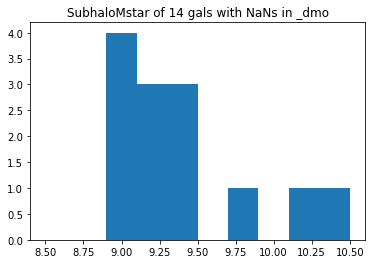

In [40]:
plt.hist(np.log10(df_wNaNs['SubhaloMstar']), bins=10, range=(8.5,10.5))
plt.title('SubhaloMstar of 14 gals with NaNs in _dmo')
plt.show()

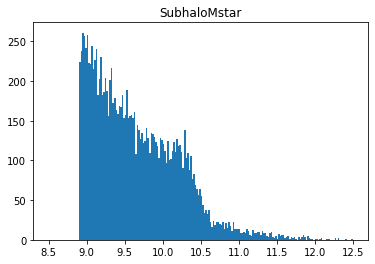

In [41]:
# np.log10(df['SubhaloMstar']).min()=8.9
# np.log10(df['SubhaloMstar']).max()=12.49
plt.hist(np.log10(df['SubhaloMstar']), bins=200, range=(8.5,12.5))
plt.title('SubhaloMstar')
plt.show()

### Conclusion: There is ~0.1% of data missing (NaNs) in the _dmo values, and I removed them from the dataset.
### Therefore, we have 12,952 central galaxies.

## Compare GroupSpin & GroupNsubs vs their _dmo versions

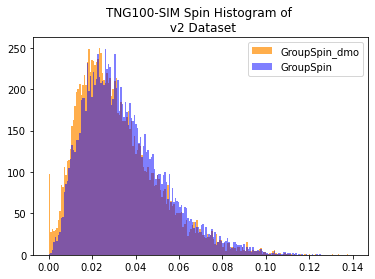

In [42]:
plt.hist(df.loc[:, 'GroupSpin_dmo'], alpha=0.7, 
         color='darkorange', bins=200, label='GroupSpin_dmo', range=(0, 0.14))
plt.hist(df.loc[:, 'GroupSpin'], alpha=0.5, 
         color='blue', bins=200, label='GroupSpin', range=(0, 0.14))
plt.title('TNG100-SIM Spin Histogram of \n v2 Dataset')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Spin_histogram_v2_dataset.jpeg', dpi=500)
plt.show()

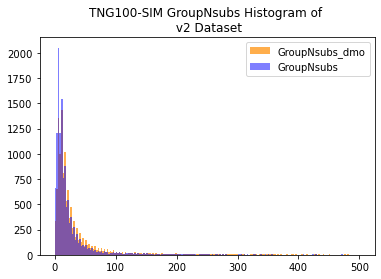

In [43]:
plt.hist(df.loc[:, 'GroupNsubs_dmo'], alpha=0.7, 
         color='darkorange', bins=200, label='GroupNsubs_dmo', range=(0, 500))
plt.hist(df.loc[:, 'GroupNsubs'], alpha=0.5, 
         color='blue', bins=200, label='GroupNsubs', range=(0, 500))
plt.title('TNG100-SIM GroupNsubs Histogram of \n v2 Dataset')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_GroupNsubs_histogram_v2_dataset.jpeg', dpi=500)
plt.show()

In [44]:
# drop all the J columns bec not needed to feed to ML model
# SubhaloCentral is True if the subhalo is a central, so we want to take only True for now (only central gals)
# GroupNsubs are the number of subhalos in the Group (that is, number of galaxies in a halo)

df = df.drop(columns=['SubhaloJx', 'SubhaloJy', 'SubhaloJz', 
                 'SubhaloJx_dmo', 'SubhaloJy_dmo', 'SubhaloJz_dmo'])
                

In [45]:
df.shape

(12952, 40)

## Calculate the percentage of zeros each columns has

In [46]:
# 1) replace 0s with NaN 2) .isnull() gives boolean (whether NaN is true or false)
# 3) .sum() sums the true instances (that is, all 0s in a column)
# 4) dividing by shape[0] divides by the number of total entries (12,966) 5) *100 to convert to percentages
100*df.replace(0, np.nan).isnull().sum()/df.shape[0] 

SubhaloBHMass              0.470970
SubhaloBHMdot              0.470970
SubhaloGasMetallicity      1.397468
SubhaloMass                0.000000
SubhaloSFRinRad            9.488882
SubhaloStarMetallicity     0.000000
SubhaloVelDisp             0.000000
SubhaloVmax                0.000000
SubhaloVmaxRad             0.000000
SubhaloRgas                0.972823
SubhaloRstar               0.000000
SubhaloMgas                3.636504
SubhaloMstar               0.000000
SubhaloCentral             0.000000
GroupNsubs                 0.000000
GroupBHMass                0.393762
GroupMass                  0.000000
Group_M_Crit200            0.000000
Group_M_TopHat200          0.000000
Group_R_Crit200            0.000000
Group_R_TopHat200          0.000000
SubhaloMHI                99.799259
SubhaloMH2                99.799259
SubhaloMass_dmo            0.000000
SubhaloVelDisp_dmo         0.000000
SubhaloVmax_dmo            0.000000
SubhaloVmaxRad_dmo         0.000000
SubhaloCentral_dmo         2

In [47]:
# calculate the percentage of 0s in each column in order to 1) remove columns of all 0s;
# 2) decide what strategy to use for columns with mostly 0s
df_percentage=pd.DataFrame(100*df.replace(0, np.nan).isnull().sum()/df.shape[0] )

In [48]:
df_percentage

,0
SubhaloBHMass,0.470970
SubhaloBHMdot,0.470970
SubhaloGasMetallicity,1.397468
SubhaloMass,0.000000
SubhaloSFRinRad,9.488882
SubhaloStarMetallicity,0.000000
SubhaloVelDisp,0.000000
SubhaloVmax,0.000000
SubhaloVmaxRad,0.000000
SubhaloRgas,0.972823


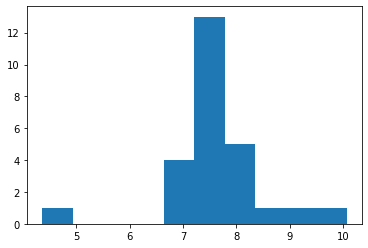

In [49]:
plt.hist(np.log10(df['SubhaloMHI']), bins=10)
plt.show()

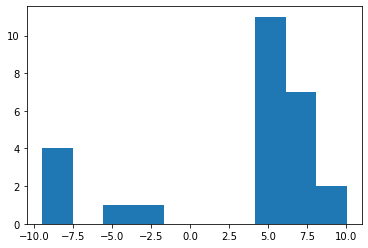

In [50]:
plt.hist(np.log10(df['SubhaloMH2']), bins=10)
plt.show()

In [51]:
df['SubhaloMH2'].replace(0, np.nan).isnull().sum()

12926

In [52]:
df['SubhaloMHI'].replace(0, np.nan).isnull().sum()

12926

Ari says that: MHI, MH2 should contain thousands not 26, so I messed up something. However, you will still need to ignore them since they will be much less than 12,940.

Therefore, even with an updated dataset, we will probably not be able to use hydrogen masses as features.

#### Conclusion: No hydrogen masses for this dataset.

In [53]:
# Save the df with the percentage of 0s of each column
# df_percentage.to_csv('TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_percentage_of_0s_per_column.csv', index=True)

### SubhaloMass & GroupMass vs their _dmo values

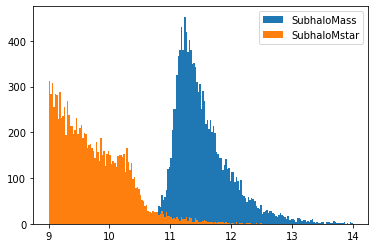

In [54]:
plt.hist(np.log10(df['SubhaloMass']), bins=200, range=(9,14),
        label='SubhaloMass')
plt.hist(np.log10(df['SubhaloMstar']), bins=200, range=(9,14),
        label='SubhaloMstar')
plt.legend()
plt.show()

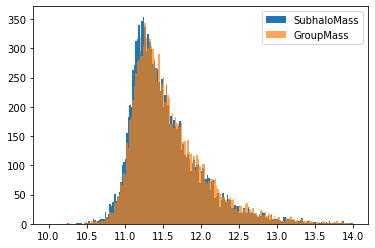

In [55]:
plt.hist(np.log10(df['SubhaloMass']), bins=200, range=(10,14),
        label='SubhaloMass')
plt.hist(np.log10(df['GroupMass']), bins=200, range=(10,14), alpha=0.7,
        label='GroupMass')
plt.legend()
plt.show()

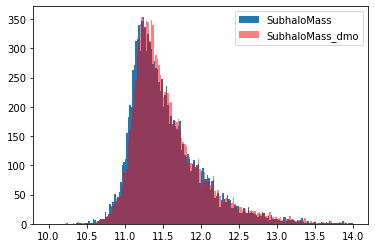

In [56]:
plt.hist(np.log10(df['SubhaloMass']), bins=200, range=(10,14),
        label='SubhaloMass')
plt.hist(np.log10(df['SubhaloMass_dmo']), bins=200, range=(10,14), alpha=0.5,
        label='SubhaloMass_dmo', color='red')
plt.legend()
plt.show()

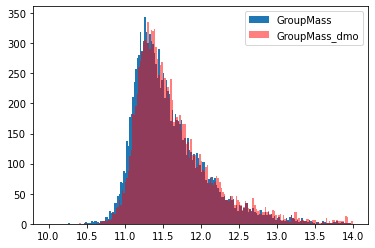

In [57]:
plt.hist(np.log10(df['GroupMass']), bins=200, range=(10,14),
        label='GroupMass')
plt.hist(np.log10(df['GroupMass_dmo']), bins=200, range=(10,14), alpha=0.5,
        label='GroupMass_dmo', color='red')
plt.legend()
plt.show()

## <font color='Green'> Central Galaxies & a Clean Feature Set

#### What are SubhaloMass and GroupMass features?
Ari: They are the same as GalpropMvir and HalopropMvir. They differ if using satellites, but are the same for centrals. There are a number of fields that can be removed because we are only looking at centrals

Conclusion: I'll drop them.

#### Which mass measurements should I use?
Ari: So the sim includes multiple ways of measuring halo properties. The TopHat values are the closest to what we used for the SAM. R for radii and V for velocities.  I think if you do the correlation analysis again you'll find that these are all highly correlated. We could use all Crit200 or all TopHat, it doesn't really matter. There is possibly some information if one compared the ratio of 2 of these, but I think that is extra feature engineering that we shouldn't bother with yet. 
The advantage of TopHat or Crit200 is they have an R and V which GroupMass /SubhaloMass doesn't.

Conclusion: I'll use TopHat values since they are closer to what we used in SAM.

#### <font color='DarkRed'> Q: How are these measurements of mass done? Why are they different? Where can I learn this?


In [58]:
df.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'SubhaloCentral',
 'GroupNsubs',
 'GroupBHMass',
 'GroupMass',
 'Group_M_Crit200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_TopHat200',
 'SubhaloMHI',
 'SubhaloMH2',
 'SubhaloMass_dmo',
 'SubhaloVelDisp_dmo',
 'SubhaloVmax_dmo',
 'SubhaloVmaxRad_dmo',
 'SubhaloCentral_dmo',
 'GroupNsubs_dmo',
 'GroupMass_dmo',
 'Group_M_Crit200_dmo',
 'Group_M_TopHat200_dmo',
 'Group_R_Crit200_dmo',
 'Group_R_TopHat200_dmo',
 'Group_V_TopHat200',
 'Group_V_Crit200',
 'GroupSpin',
 'Group_V_TopHat200_dmo',
 'Group_V_Crit200_dmo',
 'GroupSpin_dmo']

In [59]:
# Drop the two columns that define central galaxies in SIMs and DMO;
# also drop SubhaloMass and GroupMass
# also drop Crit200 values
# also drop MHI and MH2 since they are almost empty columns
# drop GroupSpin bec it is spin of dark matter + stars; we only want spin of dark matter (GroupSpin_dmo)
df_centrals = df.drop(columns=['SubhaloCentral', 'SubhaloCentral_dmo',
                      'SubhaloMass', 'GroupMass', 'SubhaloMass_dmo', 'GroupMass_dmo',
                      'Group_M_Crit200' , 'Group_R_Crit200', 'Group_V_Crit200',
                      'Group_M_Crit200_dmo', 'Group_R_Crit200_dmo', 'Group_V_Crit200_dmo',
                      'SubhaloMHI', 'SubhaloMH2',
                              'GroupSpin'])

In [60]:
df_centrals.shape

(12952, 25)

## Correlations

### <font color='DarkGreen'> Spearman Correlations of the complete raw dataset

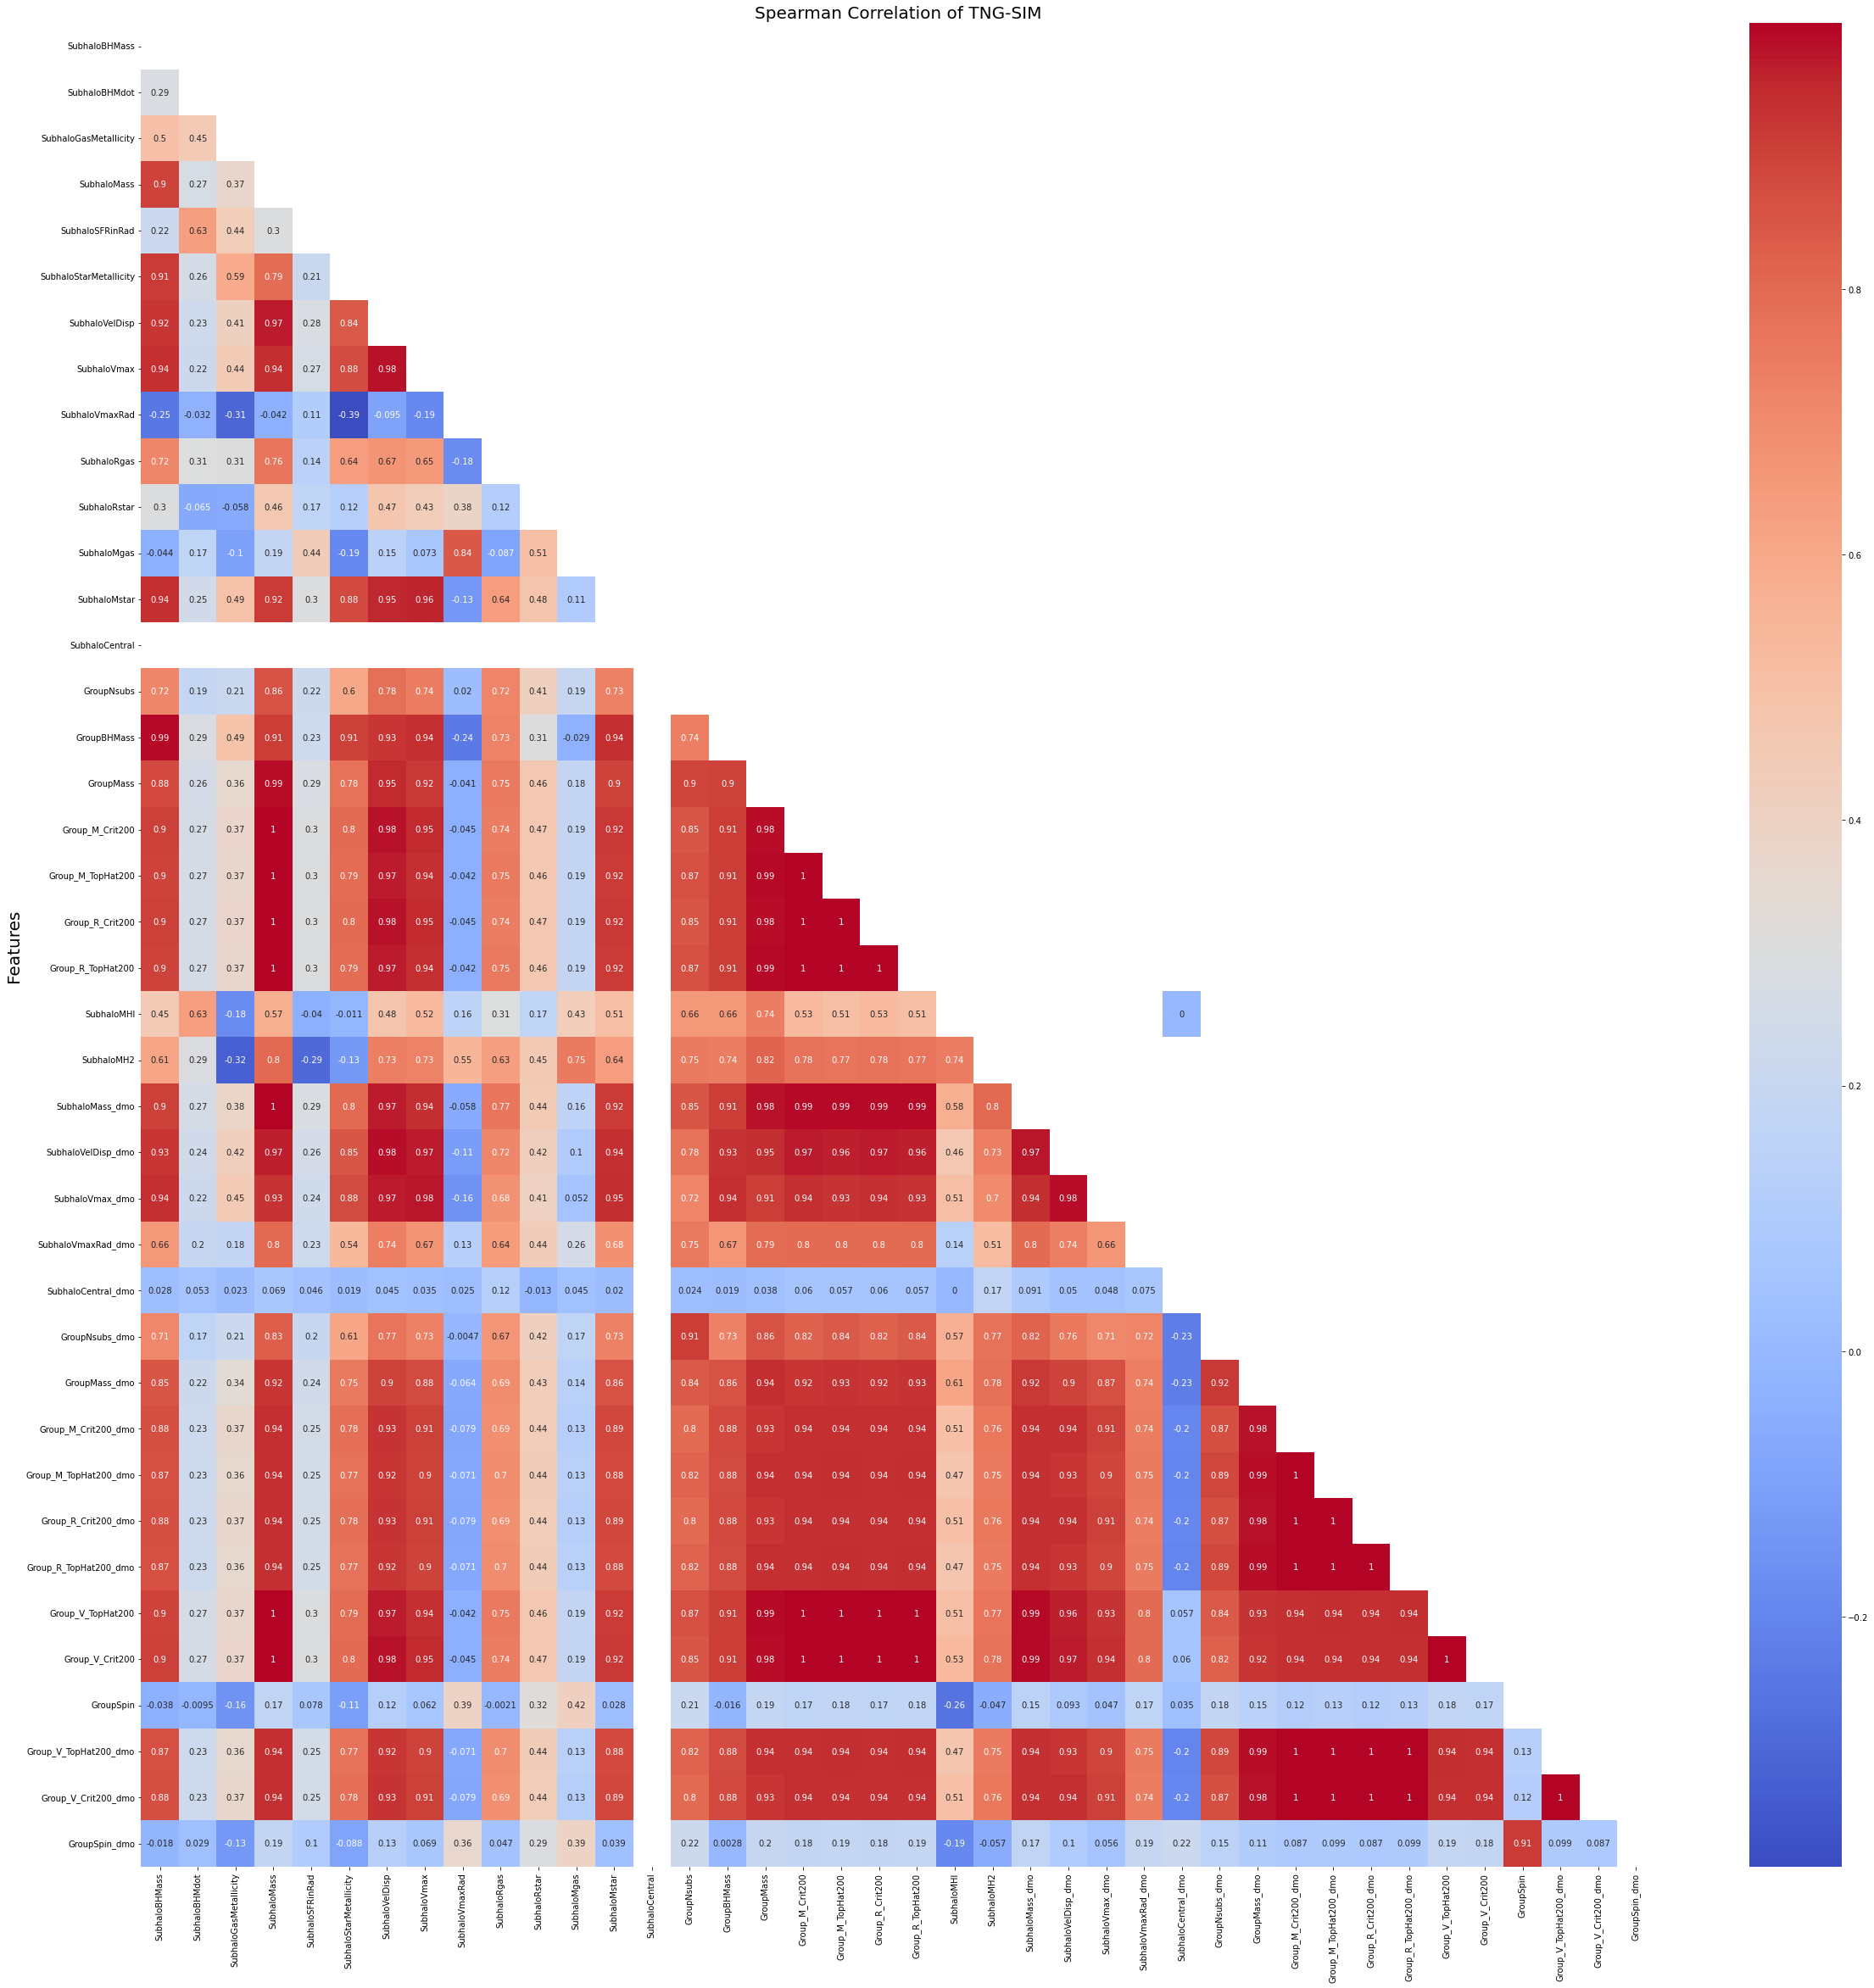

In [61]:
corr_df = df.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SIM", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_Spearman_correlation_matrix_v1.jpeg', dpi=500)
plt.show()

### <font color='DarkGreen'> Spearman Correlations of the complete dimensionless dataset


In [62]:
df_1 = df.drop(columns=['SubhaloCentral', 'SubhaloCentral_dmo', #used to define centrals, but we have already chosen only centrals
                                      'SubhaloMHI', 'SubhaloMH2', # mostly empty columns
                                      'GroupMass', 'GroupMass_dmo']) # drop since same with SubhaloMass

### Conclusion: TopHat200 and Crit200 are almost the same as their _dmo corresponding values, drop dmo values

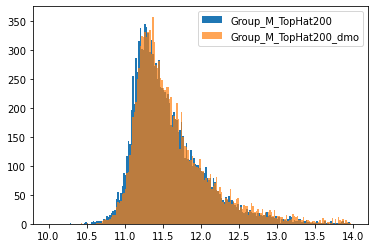

In [63]:
plt.hist(np.log10(df['Group_M_TopHat200']),
        bins=200, range=(10,14), label='Group_M_TopHat200')
plt.hist(np.log10(df['Group_M_TopHat200_dmo']),
        bins=200, range=(10,14), alpha=0.7, label='Group_M_TopHat200_dmo')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_M_TopHat200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_M_TopHat200_dmo and Group_M_TopHat200 are the same

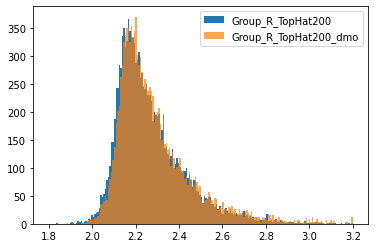

In [64]:
plt.hist(np.log10(df['Group_R_TopHat200']),
        bins=200, label='Group_R_TopHat200', range=(1.8, 3.2))
plt.hist(np.log10(df['Group_R_TopHat200_dmo']),
        bins=200, alpha=0.7, label='Group_R_TopHat200_dmo', range=(1.8, 3.2))
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_R_TopHat200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_R_TopHat200_dmo and Group_R_TopHat200 are the same

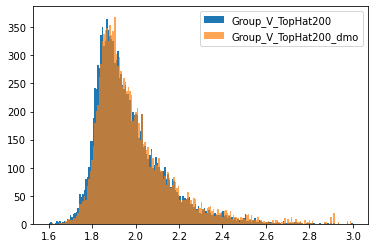

In [65]:
plt.hist(np.log10(df['Group_V_TopHat200']),
        bins=200, label='Group_V_TopHat200', range=(1.6, 3.0))
plt.hist(np.log10(df['Group_V_TopHat200_dmo']),
        bins=200, alpha=0.7, label='Group_V_TopHat200_dmo', range=(1.6, 3.0))
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_V_TopHat200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_V_TopHat200_dmo and Group_V_TopHat200 are the same

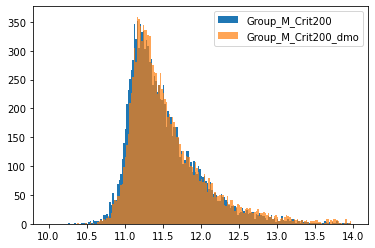

In [66]:
plt.hist(np.log10(df['Group_M_Crit200']),
        bins=200, range=(10,14), label='Group_M_Crit200')
plt.hist(np.log10(df['Group_M_Crit200_dmo']),
        bins=200, range=(10,14), alpha=0.7, label='Group_M_Crit200_dmo')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_M_Crit200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_M_Crit200_dmo and Group_M_Crit200 are the same

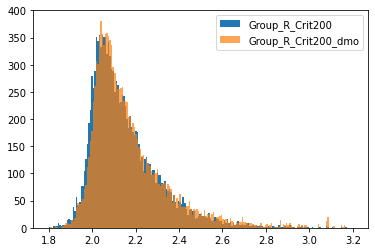

In [67]:
plt.hist(np.log10(df['Group_R_Crit200']),
        bins=200, label='Group_R_Crit200', range=(1.8, 3.2))
plt.hist(np.log10(df['Group_R_Crit200_dmo']),
        bins=200, alpha=0.7, label='Group_R_Crit200_dmo', range=(1.8, 3.2))
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_R_Crit200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_R_Crit200_dmo and Group_R_Crit200 are the same

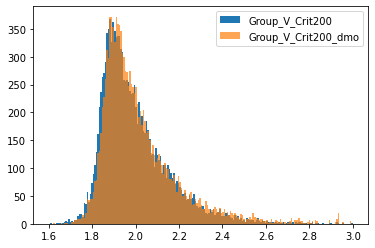

In [68]:
plt.hist(np.log10(df['Group_V_Crit200']),
        bins=200, label='Group_V_Crit200', range=(1.6, 3.0))
plt.hist(np.log10(df['Group_V_Crit200_dmo']),
        bins=200, alpha=0.7, label='Group_V_Crit200_dmo', range=(1.6, 3.0))
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_V_Crit200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_V_Crit200_dmo and Group_V_Crit200 are the same

### TopHat200 vs Crit200 values

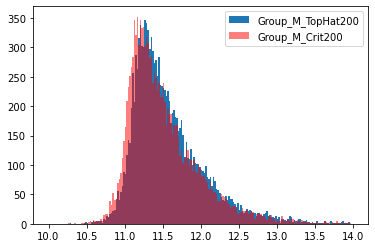

In [69]:
plt.hist(np.log10(df['Group_M_TopHat200']),
        bins=200, range=(10,14), label='Group_M_TopHat200')
plt.hist(np.log10(df['Group_M_Crit200']),
        bins=200, range=(10,14), alpha=0.5, label='Group_M_Crit200' , color='r')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_M_TopHat200_vs_Crit200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_M_TopHat200 and Group_M_Crit200 are very similar

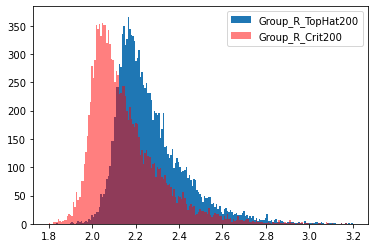

In [70]:
plt.hist(np.log10(df['Group_R_TopHat200']),
        bins=200, range=(1.8, 3.2), label='Group_R_TopHat200')
plt.hist(np.log10(df['Group_R_Crit200']),
        bins=200, range=(1.8, 3.2), alpha=0.5, label='Group_R_Crit200', color='r')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_R_TopHat200_vs_Crit200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_R_TopHat200 and Group_R_Crit200 have similar spread, but Crit200 peak is shifted to the left by 0.2

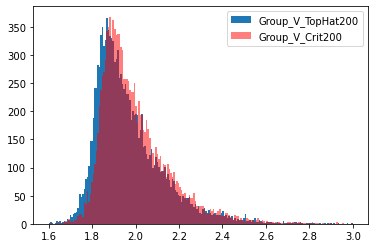

In [71]:
plt.hist(np.log10(df['Group_V_TopHat200']),
        bins=200, label='Group_V_TopHat200', range=(1.6, 3.0))
plt.hist(np.log10(df['Group_V_Crit200']),
        bins=200, alpha=0.5, label='Group_V_Crit200', range=(1.6, 3.0), color='r')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_V_TopHat200_vs_Crit200.jpeg', dpi=500)
plt.show()

# Conclusion: Group_V_TopHat200 and Group_V_Crit200 are very similar

### TopHat200 vs SubhaloMass values

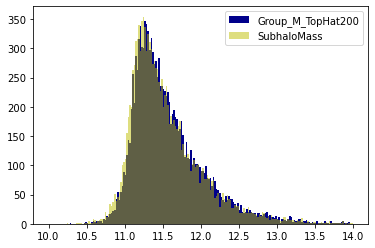

In [72]:
plt.hist(np.log10(df['Group_M_TopHat200']),
        bins=200, range=(10,14), label='Group_M_TopHat200', color='darkblue')
plt.hist(np.log10(df['SubhaloMass']),
        bins=200, range=(10,14), alpha=0.5, label='SubhaloMass' , color='y')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_M_TopHat200_vs_SubhaloMass.jpeg', dpi=500)
plt.show()

# Conclusion: Group_M_TopHat200 and SubhaloMass are almost the same

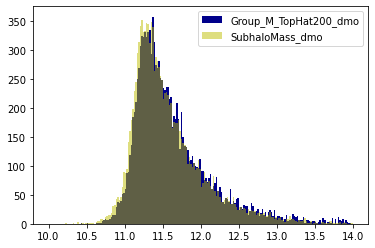

In [73]:
plt.hist(np.log10(df['Group_M_TopHat200_dmo']),
        bins=200, range=(10,14), label='Group_M_TopHat200_dmo', color='darkblue')
plt.hist(np.log10(df['SubhaloMass_dmo']),
        bins=200, range=(10,14), alpha=0.5, label='SubhaloMass_dmo' , color='y')
plt.legend()
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_Group_M_TopHat200_dmo_vs_SubhaloMass_dmo.jpeg', dpi=500)
plt.show()

# Conclusion: Group_M_TopHat200_dmo and SubhaloMass_dmo are almost the same

### Define functions

In [74]:
df.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'SubhaloCentral',
 'GroupNsubs',
 'GroupBHMass',
 'GroupMass',
 'Group_M_Crit200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_TopHat200',
 'SubhaloMHI',
 'SubhaloMH2',
 'SubhaloMass_dmo',
 'SubhaloVelDisp_dmo',
 'SubhaloVmax_dmo',
 'SubhaloVmaxRad_dmo',
 'SubhaloCentral_dmo',
 'GroupNsubs_dmo',
 'GroupMass_dmo',
 'Group_M_Crit200_dmo',
 'Group_M_TopHat200_dmo',
 'Group_R_Crit200_dmo',
 'Group_R_TopHat200_dmo',
 'Group_V_TopHat200',
 'Group_V_Crit200',
 'GroupSpin',
 'Group_V_TopHat200_dmo',
 'Group_V_Crit200_dmo',
 'GroupSpin_dmo']

In [75]:
def normalization_func(df):
    '''
    Normalizes the dataset by dividing all masses by halo mass, and galaxy size by halo size

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    
    df =df.copy()
    
    # define halomass, halo radius and halo velocity
    halomass=df.loc[:,'Group_M_TopHat200'] # Q: ShoulD I use this, or the _dmo version of it? Why? Ans: Looking at the histogram, they seem to be the same, so use this mass
    halorad= df.loc[:,'Group_R_TopHat200']
    halovel= df.loc[:,'Group_V_TopHat200']
    
    # dimensionless form of halfmass radius, Rgas and the radius at which Vmax occurs
    df.loc[:,'SubhaloRstar_0D']=df.loc[:,'SubhaloRstar']/halorad # halfmass radius
    df.loc[:,'SubhaloRgas_0D']=df.loc[:,'SubhaloRgas']/halorad # galaxy size in gas? 
    df.loc[:,'SubhaloVmaxRad_0D']=df.loc[:,'SubhaloVmaxRad']/halorad # Vmax is the maximum circular velocity. VmaxRad is the radius at which Vmax occurs. 
    df.loc[:,'SubhaloVmaxRad_dmo_0D']=df.loc[:,'SubhaloVmaxRad_dmo']/halorad
    
    # dimensionless form of circular velocities
    df.loc[:,'SubhaloVmax_0D']=df.loc[:,'SubhaloVmax']/halovel 
    df.loc[:,'SubhaloVmax_dmo_0D']=df.loc[:,'SubhaloVmax_dmo']/halovel
    df.loc[:,'SubhaloVelDisp_0D']=df.loc[:,'SubhaloVelDisp']/halovel 
    df.loc[:,'SubhaloVelDisp_dmo_0D']=df.loc[:,'SubhaloVelDisp_dmo']/halovel
   
    
    # dimensionless form of masses
    df.loc[:,'SubhaloMgas_0D']=df.loc[:,'SubhaloMgas']/halomass 
    df.loc[:,'SubhaloMstar_0D']=df.loc[:,'SubhaloMstar']/halomass
    df.loc[:,'SubhaloBHMass_0D']=df.loc[:,'SubhaloBHMass']/halomass
    df.loc[:,'GroupBHMass_0D']=df.loc[:,'GroupBHMass']/halomass
    df.loc[:,'SubhaloBHMdot_0D']=df.loc[:,'SubhaloBHMdot']/halomass
    
    # dimensionless form of different forms of halo sizes (not very imp)
    df.loc[:,'Group_R_TopHat200_0D']=df.loc[:,'Group_R_TopHat200']/halorad # this is 1
    df.loc[:,'Group_R_TopHat200_dmo_0D']=df.loc[:,'Group_R_TopHat200_dmo']/halorad # this is R_TopHat200_dmo/R_TopHat200
    df.loc[:,'Group_R_Crit200_0D']=df.loc[:,'Group_R_Crit200']/halorad # this is # this is R_Crit200/R_TopHat200
    df.loc[:,'Group_R_Crit200_dmo_0D']=df.loc[:,'Group_R_Crit200_dmo']/halorad # this is R_Crit200_dmo/R_TopHat200

    # dimensionless form of different forms of halo masses (not very imp)
    df.loc[:,'Group_M_TopHat200_0D']=df.loc[:,'Group_M_TopHat200']/halomass # this is 1
    df.loc[:,'Group_M_TopHat200_dmo_0D']=df.loc[:,'Group_M_TopHat200_dmo']/halomass # this is M_TopHat200_dmo/M_TopHat200, should be almost 1
    df.loc[:,'Group_M_Crit200_0D']=df.loc[:,'Group_M_Crit200']/halomass # this is # this is M_Crit200/M_TopHat200
    df.loc[:,'Group_M_Crit200_dmo_0D']=df.loc[:,'Group_M_Crit200_dmo']/halomass # this is M_Crit200_dmo/M_TopHat200
    df.loc[:,'SubhaloMass_0D']=df.loc[:,'SubhaloMass']/halomass
    df.loc[:,'SubhaloMass_dmo_0D']=df.loc[:,'SubhaloMass_dmo']/halomass
#     df.loc[:,'GroupMass_0D']=df.loc[:,'GroupMass']/halomass
#     df.loc[:,'GroupMass_dmo_0D']=df.loc[:,'GroupMass_dmo']/halomass
    
    # dimensionless form of different forms of halo velocities (not very imp)
    df.loc[:,'Group_V_TopHat200_0D']=df.loc[:,'Group_V_TopHat200']/halovel # this is 1
    df.loc[:,'Group_V_TopHat200_dmo_0D']=df.loc[:,'Group_V_TopHat200_dmo']/halovel # this is V_TopHat200_dmo/V_TopHat200, should be almost 1
    df.loc[:,'Group_V_Crit200_0D']=df.loc[:,'Group_V_Crit200']/halovel # this is # this is V_Crit200/V_TopHat200
    df.loc[:,'Group_V_Crit200_dmo_0D']=df.loc[:,'Group_V_Crit200_dmo']/halovel # this is V_Crit200_dmo/V_TopHat200

    # 28 lines
    return df

In [76]:
df_0D = normalization_func(df_1)

In [77]:
df_0D.shape

(12952, 61)

In [78]:
df_0D_clean = df_0D.drop(columns=['Group_M_TopHat200', 'Group_R_TopHat200', 'Group_V_TopHat200', # cols used for normalization
                                'Group_M_TopHat200_0D', 'Group_R_TopHat200_0D', 'Group_V_TopHat200_0D',
                                'Group_M_TopHat200_dmo', 'Group_R_TopHat200_dmo', 'Group_V_TopHat200_dmo',
                                'Group_M_Crit200', 'Group_R_Crit200', 'Group_V_Crit200',
                                'Group_M_Crit200_dmo', 'Group_R_Crit200_dmo', 'Group_V_Crit200_dmo',
                                'SubhaloMass', 'SubhaloMass_dmo',
                                'SubhaloVmax', 'SubhaloVmax_dmo',
                                'SubhaloVelDisp', 'SubhaloVelDisp_dmo',
                                'SubhaloVmaxRad', 'SubhaloVmaxRad_dmo',
                                'SubhaloRstar', 'SubhaloRgas',
                                'SubhaloMstar', 'SubhaloMgas',
                                'SubhaloBHMass', 'GroupBHMass', 'SubhaloBHMdot' ])

In [79]:
df_0D_clean.shape

(12952, 31)

In [80]:
df_0D_clean

,SubhaloGasMetallicity,SubhaloSFRinRad,SubhaloStarMetallicity,GroupNsubs,GroupNsubs_dmo,GroupSpin,GroupSpin_dmo,SubhaloRstar_0D,SubhaloRgas_0D,SubhaloVmaxRad_0D,SubhaloVmaxRad_dmo_0D,SubhaloVmax_0D,SubhaloVmax_dmo_0D,SubhaloVelDisp_0D,SubhaloVelDisp_dmo_0D,SubhaloMgas_0D,SubhaloMstar_0D,SubhaloBHMass_0D,GroupBHMass_0D,SubhaloBHMdot_0D,Group_R_TopHat200_dmo_0D,Group_R_Crit200_0D,Group_R_Crit200_dmo_0D,Group_M_TopHat200_dmo_0D,Group_M_Crit200_0D,Group_M_Crit200_dmo_0D,SubhaloMass_0D,SubhaloMass_dmo_0D,Group_V_TopHat200_dmo_0D,Group_V_Crit200_0D,Group_V_Crit200_dmo_0D
0,0.007718,0.195825,0.028622,17185,24681.0,0.015910,0.016995,0.034353,0.454753,0.237651,0.265355,1.012913,0.995211,0.612050,0.643730,0.027866,0.007087,0.000022,0.000081,8.972381e-19,0.995465,0.747883,0.739507,0.986359,0.817359,0.790180,0.879883,0.921318,0.995416,1.045417,1.033693
17185,0.004368,1.657662,0.020940,14157,19381.0,0.013266,0.012785,0.062079,0.481878,0.674877,0.686944,0.942593,0.899316,0.584577,0.614626,0.083750,0.004260,0.000016,0.000055,1.997091e-19,0.982731,0.727770,0.707076,0.949029,0.753166,0.690730,0.801144,0.795196,0.982703,1.017298,0.988374
31342,0.005708,1.530534,0.022085,10240,14812.0,0.034117,0.032441,0.044287,0.407886,0.470064,0.437582,1.043623,1.022490,0.601488,0.630259,0.073389,0.006562,0.000031,0.000067,9.622102e-19,0.997390,0.754502,0.745619,0.992264,0.839354,0.809951,0.852074,0.858067,0.997427,1.054732,1.042247
41582,0.014258,98.666870,0.023172,11036,15339.0,0.021438,0.026528,0.018732,0.401898,0.276922,0.294140,1.101144,1.083645,0.614389,0.642960,0.045557,0.006070,0.000022,0.000115,5.275731e-18,0.989166,0.743115,0.732974,0.967882,0.801853,0.769542,0.952372,0.978385,0.989183,1.038770,1.024641
52618,0.004526,1.724860,0.021753,8113,11085.0,0.043523,0.037578,0.029782,0.421826,0.578710,0.594200,0.942282,0.921877,0.580719,0.612611,0.084787,0.003724,0.000012,0.000052,2.908380e-18,0.998056,0.752716,0.753205,0.994209,0.833289,0.834886,0.751044,0.741059,0.998071,1.052161,1.052827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768905,0.000000,0.000000,0.008719,1,2.0,0.010672,0.009537,0.045176,0.000000,0.065972,0.112427,1.964937,1.997739,1.005771,1.007577,0.000000,0.024567,0.000000,0.000000,0.000000e+00,1.130273,0.778369,0.873554,1.443883,0.921312,1.302240,0.874797,1.276383,1.130249,1.087954,1.220958
770944,0.000000,0.000000,0.009717,2,2680.0,0.008078,0.000051,0.033605,0.000000,0.046445,0.086415,2.064013,1.985215,1.015832,1.001151,0.000000,0.032387,0.000000,0.000000,0.000000e+00,14.136653,0.760225,10.866847,2825.029826,0.858558,2507.151407,0.826914,0.896926,14.136381,1.062708,15.189327
776030,0.000000,0.000000,0.008567,2,10833.0,0.006247,0.000011,0.044345,0.000000,0.076798,0.097633,1.743768,1.642926,0.876628,0.868432,0.000000,0.026400,0.000000,0.000000,0.000000e+00,20.005886,0.767621,14.984964,8007.603704,0.883804,6574.568582,0.804395,0.548125,20.006558,1.073012,20.946225
780034,0.000000,0.000000,0.008901,1,1.0,0.004403,0.012860,0.036871,0.000000,0.059992,0.098267,1.784825,1.831721,0.918654,0.937814,0.000000,0.027239,0.000095,0.000095,7.466619e-23,1.010155,0.787486,0.796250,1.030754,0.954137,0.986544,0.932470,0.973951,1.010145,1.100738,1.113099


In [81]:
df_0D_clean.columns.to_list()

['SubhaloGasMetallicity',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'GroupNsubs',
 'GroupNsubs_dmo',
 'GroupSpin',
 'GroupSpin_dmo',
 'SubhaloRstar_0D',
 'SubhaloRgas_0D',
 'SubhaloVmaxRad_0D',
 'SubhaloVmaxRad_dmo_0D',
 'SubhaloVmax_0D',
 'SubhaloVmax_dmo_0D',
 'SubhaloVelDisp_0D',
 'SubhaloVelDisp_dmo_0D',
 'SubhaloMgas_0D',
 'SubhaloMstar_0D',
 'SubhaloBHMass_0D',
 'GroupBHMass_0D',
 'SubhaloBHMdot_0D',
 'Group_R_TopHat200_dmo_0D',
 'Group_R_Crit200_0D',
 'Group_R_Crit200_dmo_0D',
 'Group_M_TopHat200_dmo_0D',
 'Group_M_Crit200_0D',
 'Group_M_Crit200_dmo_0D',
 'SubhaloMass_0D',
 'SubhaloMass_dmo_0D',
 'Group_V_TopHat200_dmo_0D',
 'Group_V_Crit200_0D',
 'Group_V_Crit200_dmo_0D']

In [82]:
# Drop the two columns that define central galaxies in SIMs and DMO;
# also drop SubhaloMass and GroupMass
# also drop Crit200 values
# also drop MHI and MH2 since they are almost empty columns
# drop GroupSpin bec it is spin of dark matter + stars; we only want spin of dark matter (GroupSpin_dmo)
df_centrals_0D = df_0D_clean.drop(columns=[ 'SubhaloMass_0D', 'SubhaloMass_dmo_0D',
                      'Group_M_Crit200_0D' , 'Group_R_Crit200_0D', 'Group_V_Crit200_0D',
                      'Group_M_Crit200_dmo_0D', 'Group_R_Crit200_dmo_0D', 'Group_V_Crit200_dmo_0D',
                      'GroupSpin'])

In [83]:
df_centrals_0D.shape

(12952, 22)

In [84]:
# df_centrals (shape (12952, 25))
# is the raw dataset to be used for ML (note: may need to remove the TopHat200_dmo values)
df_centrals.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'GroupNsubs',
 'GroupBHMass',
 'Group_M_TopHat200',
 'Group_R_TopHat200',
 'SubhaloVelDisp_dmo',
 'SubhaloVmax_dmo',
 'SubhaloVmaxRad_dmo',
 'GroupNsubs_dmo',
 'Group_M_TopHat200_dmo',
 'Group_R_TopHat200_dmo',
 'Group_V_TopHat200',
 'Group_V_TopHat200_dmo',
 'GroupSpin_dmo']

In [85]:
# df_centrals (shape (12952, 22)) is the dimensionless dataset to be used for ML 
#(note: may need to remove the TopHat200_dmo values;
# note2: this dataset has 3 features less because they are the features used to make it dimensionless)

df_centrals_0D.columns.to_list()

['SubhaloGasMetallicity',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'GroupNsubs',
 'GroupNsubs_dmo',
 'GroupSpin_dmo',
 'SubhaloRstar_0D',
 'SubhaloRgas_0D',
 'SubhaloVmaxRad_0D',
 'SubhaloVmaxRad_dmo_0D',
 'SubhaloVmax_0D',
 'SubhaloVmax_dmo_0D',
 'SubhaloVelDisp_0D',
 'SubhaloVelDisp_dmo_0D',
 'SubhaloMgas_0D',
 'SubhaloMstar_0D',
 'SubhaloBHMass_0D',
 'GroupBHMass_0D',
 'SubhaloBHMdot_0D',
 'Group_R_TopHat200_dmo_0D',
 'Group_M_TopHat200_dmo_0D',
 'Group_V_TopHat200_dmo_0D']

df_centrals is the raw dataset to use for ML

df_centrals_0D is the dimensionless dataset to use for ML

In both cases, the _dmo values should be removed before analysis.


In [86]:
df_centrals_raw = df_centrals.drop(columns=[ 'SubhaloVelDisp_dmo','SubhaloVmax_dmo','SubhaloVmaxRad_dmo',
                                             'GroupNsubs_dmo','Group_M_TopHat200_dmo','Group_R_TopHat200_dmo', 
                                             'Group_V_TopHat200_dmo'])

In [87]:
# 17 available features to predict target (Rstar)
df_centrals_raw.shape

(12952, 18)

## Save the RAW Dataset

In [88]:
# save the raw dataset
# df_centrals_raw.to_csv('TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_Raw_Dataset.csv', index=False)

In [89]:
df_centrals_0D_final = df_centrals_0D.drop(columns=['SubhaloVelDisp_dmo_0D', 'SubhaloVmax_dmo_0D', 'SubhaloVmaxRad_dmo_0D',
                                                   'GroupNsubs_dmo', 'Group_M_TopHat200_dmo_0D', 'Group_R_TopHat200_dmo_0D',
                                                   'Group_V_TopHat200_dmo_0D'])

In [90]:
# 14 available features to predict target (Rstar)
df_centrals_0D_final.shape

(12952, 15)

## Save the 0D Dataset

In [91]:
# save the dimensionless dataset
# df_centrals_0D_final.to_csv('TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_0D_Dataset.csv', index=False)

### <font color='DarkGreen'> Spearman Correlations of the complete D0 dataset

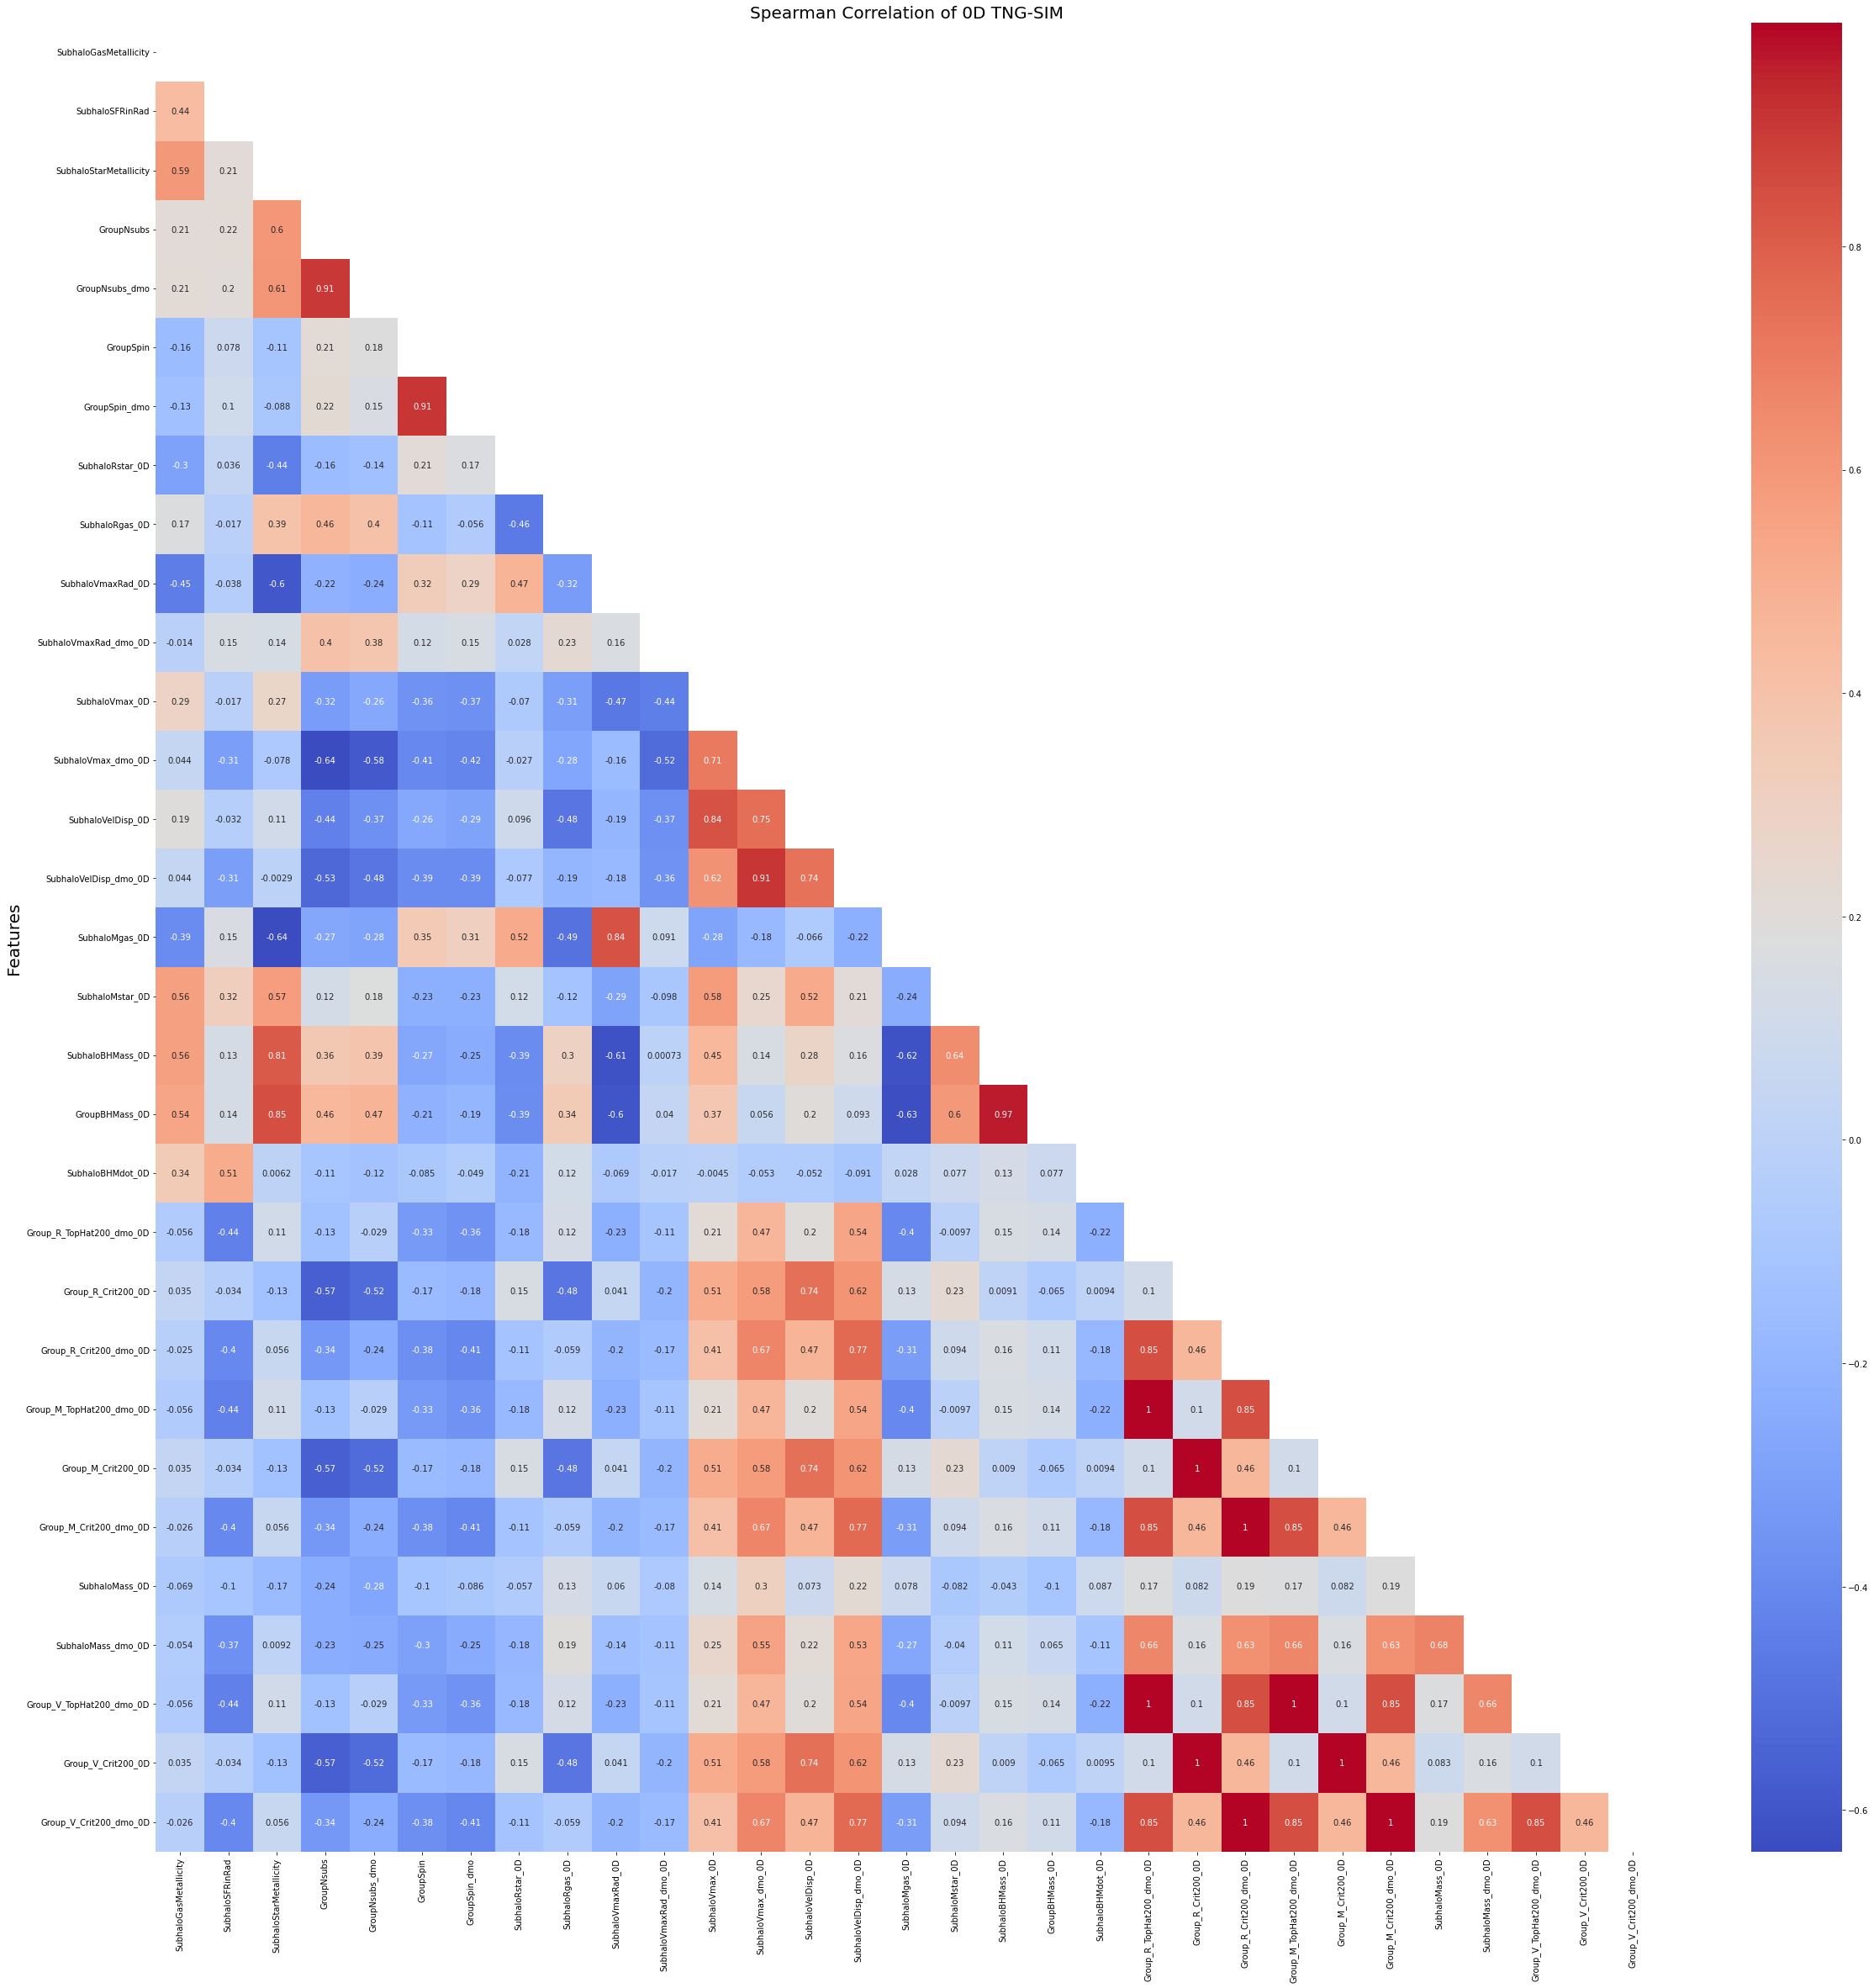

In [93]:
corr_df_0D = df_0D_clean.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df_0D) # take upper correlation matrix
sns.heatmap(corr_df_0D, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of 0D TNG-SIM", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
# plt.savefig('TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_Spearman_correlation_matrix_0Ddataset_v1.jpeg', dpi=500)
plt.show()

### <font color='darkviolet'> Size, Mass and Halo Spin plot

In [94]:
mass_size_corr = round(stats.spearmanr(df['SubhaloMstar'], 
                                               df['SubhaloRstar'])[0], 2)
# SFR_size_corr = round(stats.spearmanr(df_centrals_log['GalpropLogSfr'], 
#                                               df_centrals_log['GalpropLogHalfRadius'] )[0], 2)
# SFR_mass_corr = round(stats.spearmanr(df_centrals_log['GalpropLogSfr'], 
#                                               df_centrals_log['GalpropLogMstar'] )[0], 2)
mom_size_corr = round(stats.spearmanr(df['GroupSpin_dmo'], 
                                              df['SubhaloRstar'])[0], 2)
print('mass_size_corr:', mass_size_corr)
# print('SFR_size_corr:', SFR_size_corr)
# print('SFR_mass_corr:', SFR_mass_corr)
print('mom_size_corr:', mom_size_corr)

mass_size_corr: 0.48
mom_size_corr: 0.29


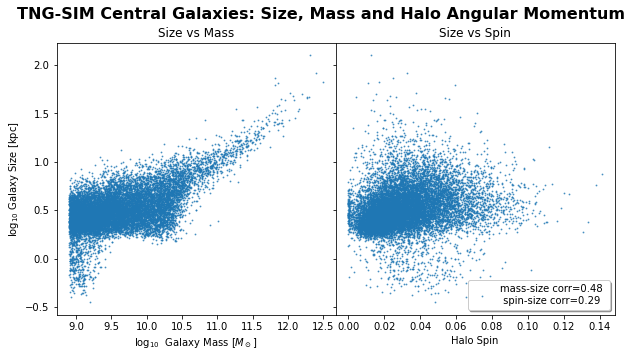

In [95]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG-SIM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(np.log10(df['SubhaloMstar']), np.log10(df['SubhaloRstar']), 
                    s=3, marker='.', alpha=0.7) # , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

# ax1.set_xlim([8.0, 11.5])
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([-1.0,1.5])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = 'mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df['GroupSpin_dmo'], np.log10(df['SubhaloRstar']), 
                     s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_centrals_Mass_Size_AngMom.jpeg", dpi=500)
plt.show()

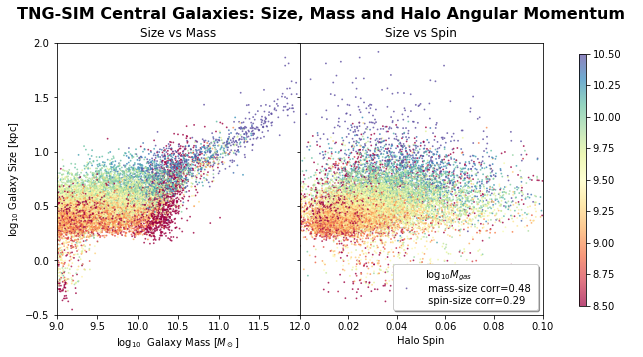

In [96]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG-SIM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(np.log10(df['SubhaloMstar']), np.log10(df['SubhaloRstar']), 
#                     s=3, marker='.', alpha=0.7) # , vmin=-2, vmax=1.0)
                  c = (df.loc[:,'SubhaloMgas'].apply(lambda x: np.log10(x) if x>0 else 0)), 
                  s=3, marker='.', cmap='Spectral', alpha=0.7 , vmin=8.5, vmax=10.5)#, label=label)

ax1.set_xlim([9.0, 12.0])
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-0.5,2.0])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = r'$\log_{10}M_{gas}$' + '\n mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df['GroupSpin_dmo'], np.log10(df['SubhaloRstar']), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
                  c  = (df.loc[:,'SubhaloMgas'].apply(lambda x: np.log10(x) if x>0 else 0)),  
                  s=3, marker='.', alpha=0.7,cmap='Spectral', label= label, vmin=8.5, vmax=10.5)

ax2.set_xlim([0.0,0.1])
ax2.set_xticks([ 0.02, 0.04, 0.06, 0.08, 0.1])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_centrals_Mass_Size_AngMom_colorMgas.jpeg", dpi=500)
plt.show()

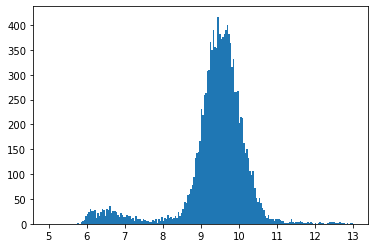

In [97]:
plt.hist((df.loc[:,'SubhaloMgas'].apply(lambda x: np.log10(x) if x>0 else 0)),
        bins=200, range=(5,13))
plt.show()

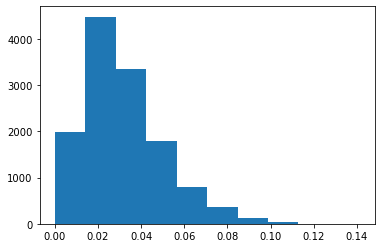

In [98]:
plt.hist(df.loc[:, 'GroupSpin_dmo'])
plt.show()

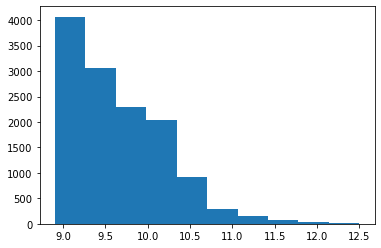

In [99]:
plt.hist(np.log10(df['SubhaloMstar']))
plt.show()

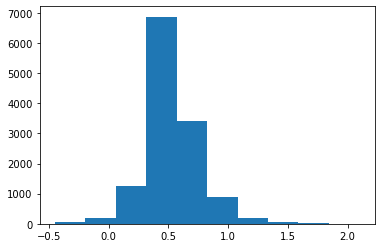

In [100]:
plt.hist(np.log10(df['SubhaloRstar']))
plt.show()

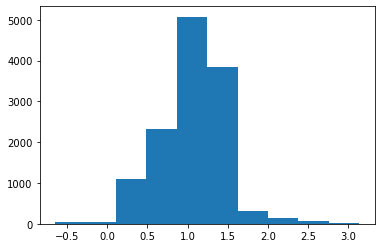

In [101]:
plt.hist(np.log10(df.loc[:, 'SubhaloVmaxRad']))
plt.show()

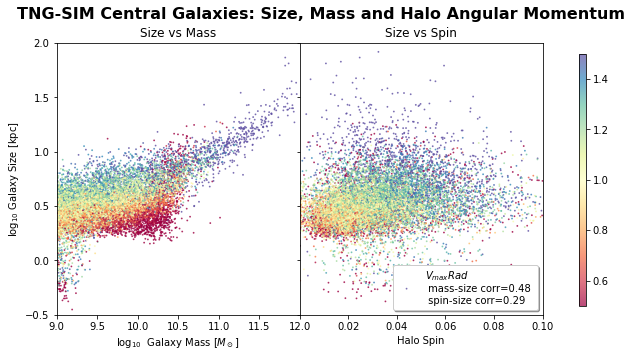

In [102]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG-SIM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(np.log10(df['SubhaloMstar']), np.log10(df['SubhaloRstar']), 
#                     s=3, marker='.', alpha=0.7) # , vmin=-2, vmax=1.0)
                  c = np.log10(df.loc[:, 'SubhaloVmaxRad']), 
                  s=3, marker='.', cmap='Spectral', alpha=0.7 , vmin=0.5, vmax=1.5)#, label=label)

ax1.set_xlim([9.0, 12.0])
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-0.5,2.0])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = r'$V_{max}Rad$' + '\n mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df['GroupSpin_dmo'], np.log10(df['SubhaloRstar']), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
                  c  = np.log10(df.loc[:, 'SubhaloVmaxRad']),  
                  s=3, marker='.', alpha=0.7,cmap='Spectral', label= label, vmin=0.5, vmax=1.5)

ax2.set_xlim([0.0,0.1])
ax2.set_xticks([ 0.02, 0.04, 0.06, 0.08, 0.1])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_centrals_Mass_Size_AngMom_colorVmaxRad.jpeg", dpi=500)
plt.show()

### 0D Dataset Mass, Size, Spin Plot

In [103]:
mass_size_corr_0D = round(stats.spearmanr(df_0D_clean['SubhaloMstar_0D'], 
                                               df_0D_clean['SubhaloRstar_0D'])[0], 2)
# SFR_size_corr = round(stats.spearmanr(df_centrals_log['GalpropLogSfr'], 
#                                               df_centrals_log['GalpropLogHalfRadius'] )[0], 2)
# SFR_mass_corr = round(stats.spearmanr(df_centrals_log['GalpropLogSfr'], 
#                                               df_centrals_log['GalpropLogMstar'] )[0], 2)
mom_size_corr_0D = round(stats.spearmanr(df_0D_clean['GroupSpin_dmo'], 
                                              df_0D_clean['SubhaloRstar_0D'])[0], 2)
print('mass_size_corr_0D:', mass_size_corr_0D)
# print('SFR_size_corr:', SFR_size_corr)
# print('SFR_mass_corr:', SFR_mass_corr)
print('mom_size_corr_0D:', mom_size_corr_0D)

mass_size_corr_0D: 0.12
mom_size_corr_0D: 0.17


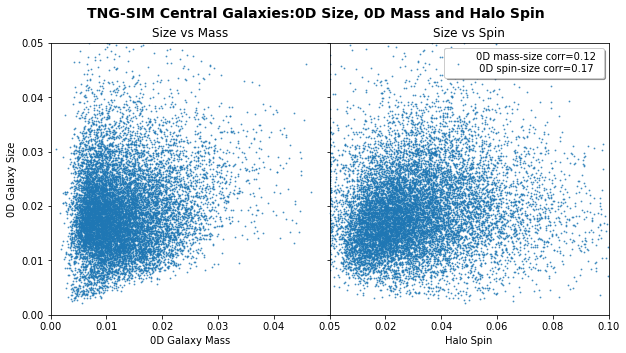

In [104]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG-SIM Central Galaxies:0D Size, 0D Mass and Halo Spin  ', fontsize=14, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_0D_clean['SubhaloMstar_0D'], df_0D_clean['SubhaloRstar_0D'], 
                    s=3, marker='.', alpha=0.7) # , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

ax1.set_xlim([0.0, 0.05])
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([0.0,0.05])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('0D Galaxy Mass')
ax1.set_ylabel('0D Galaxy Size')
# ax1.legend(loc='lower right', shadow=True)


label = '0D mass-size corr={} \n 0D spin-size corr={}'.format(mass_size_corr_0D, mom_size_corr_0D )
im2 = ax2.scatter(df_0D_clean['GroupSpin_dmo'], df_0D_clean['SubhaloRstar_0D'], 
                     s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

ax2.set_xlim([0.0,0.1])
ax2.set_xticks([ 0.02, 0.04, 0.06, 0.08, 0.1])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_centrals_0D_Mass_Size_AngMom.jpeg", dpi=500)
plt.show()

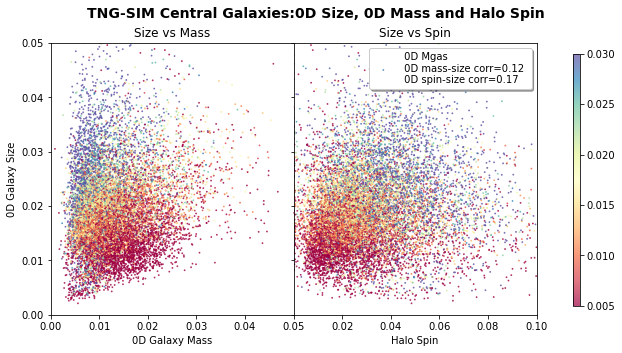

In [105]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG-SIM Central Galaxies:0D Size, 0D Mass and Halo Spin  ', fontsize=14, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_0D_clean['SubhaloMstar_0D'], df_0D_clean['SubhaloRstar_0D'], 
#                     s=3, marker='.', alpha=0.7) 
                  c = df_0D_clean.loc[:,'SubhaloMgas_0D'],  s=3, marker='.', 
                  cmap='Spectral', alpha=0.7, vmin=0.005, vmax=0.03)#, label=label)

ax1.set_xlim([0.0, 0.05])
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([0.0,0.05])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('0D Galaxy Mass')
ax1.set_ylabel('0D Galaxy Size')
# ax1.legend(loc='lower right', shadow=True)


label = ' 0D Mgas \n 0D mass-size corr={} \n 0D spin-size corr={}'.format(mass_size_corr_0D, mom_size_corr_0D )
im2 = ax2.scatter(df_0D_clean['GroupSpin_dmo'], df_0D_clean['SubhaloRstar_0D'], 
#                      s=3, marker='.', alpha=0.7,label= label)
                  c = df_0D_clean.loc[:,'SubhaloMgas_0D'],  s=3, marker='.', 
                  cmap='Spectral', alpha=0.7,label= label, vmin=0.005, vmax=0.03)

ax2.set_xlim([0.0,0.1])
ax2.set_xticks([ 0.02, 0.04, 0.06, 0.08, 0.1])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper right' , shadow=True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_centrals_0D_Mass_Size_AngMom_colorMgas.jpeg", dpi=500)
plt.show()

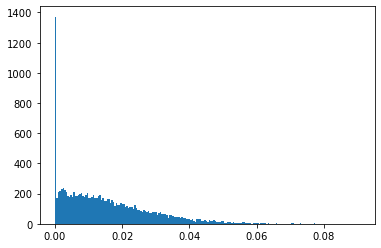

In [106]:
plt.hist(df_0D_clean.loc[:,'SubhaloMgas_0D'], bins=200)
plt.show()

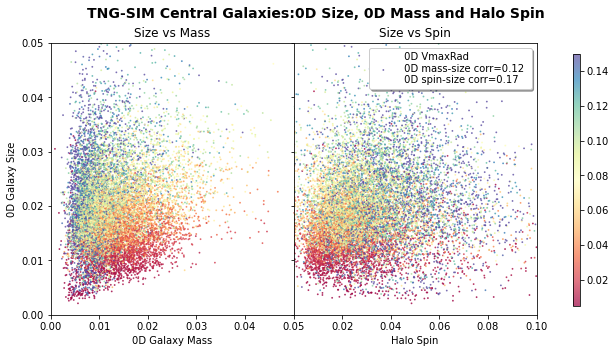

In [107]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG-SIM Central Galaxies:0D Size, 0D Mass and Halo Spin  ', fontsize=14, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_0D_clean['SubhaloMstar_0D'], df_0D_clean['SubhaloRstar_0D'], 
#                     s=3, marker='.', alpha=0.7) 
                  c = df_0D_clean.loc[:,'SubhaloVmaxRad_0D'],  s=3, marker='.', 
                  cmap='Spectral', alpha=0.7, vmin=0.005, vmax=0.15)#, label=label)

ax1.set_xlim([0.0, 0.05])
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([0.0,0.05])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('0D Galaxy Mass')
ax1.set_ylabel('0D Galaxy Size')
# ax1.legend(loc='lower right', shadow=True)


label = ' 0D VmaxRad \n 0D mass-size corr={} \n 0D spin-size corr={}'.format(mass_size_corr_0D, mom_size_corr_0D )
im2 = ax2.scatter(df_0D_clean['GroupSpin_dmo'], df_0D_clean['SubhaloRstar_0D'], 
#                      s=3, marker='.', alpha=0.7,label= label)
                  c = df_0D_clean.loc[:,'SubhaloVmaxRad_0D'],  s=3, marker='.', 
                  cmap='Spectral', alpha=0.7,label= label, vmin=0.005, vmax=0.15)

ax2.set_xlim([0.0,0.1])
ax2.set_xticks([ 0.02, 0.04, 0.06, 0.08, 0.1])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper right' , shadow=True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_centrals_0D_Mass_Size_AngMom_colorVmaxRad.jpeg", dpi=500)
plt.show()

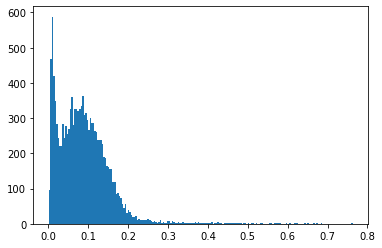

In [108]:
plt.hist(df_0D_clean.loc[:,'SubhaloVmaxRad_0D'], bins=200)
plt.show()

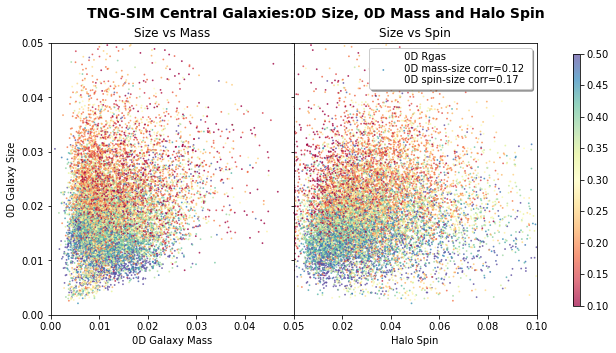

In [109]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle('TNG-SIM Central Galaxies:0D Size, 0D Mass and Halo Spin  ', fontsize=14, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_0D_clean['SubhaloMstar_0D'], df_0D_clean['SubhaloRstar_0D'], 
#                     s=3, marker='.', alpha=0.7) 
                  c = df_0D_clean.loc[:,'SubhaloRgas_0D'],  s=3, marker='.', 
                  cmap='Spectral', alpha=0.7, vmin=0.1, vmax=0.5)#, label=label)

ax1.set_xlim([0.0, 0.05])
# ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([0.0,0.05])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('0D Galaxy Mass')
ax1.set_ylabel('0D Galaxy Size')
# ax1.legend(loc='lower right', shadow=True)


label = ' 0D Rgas \n 0D mass-size corr={} \n 0D spin-size corr={}'.format(mass_size_corr_0D, mom_size_corr_0D )
im2 = ax2.scatter(df_0D_clean['GroupSpin_dmo'], df_0D_clean['SubhaloRstar_0D'], 
#                      s=3, marker='.', alpha=0.7,label= label)
                  c = df_0D_clean.loc[:,'SubhaloRgas_0D'],  s=3, marker='.', 
                  cmap='Spectral', alpha=0.7,label= label, vmin=0.1, vmax=0.5)

ax2.set_xlim([0.0,0.1])
ax2.set_xticks([ 0.02, 0.04, 0.06, 0.08, 0.1])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper right' , shadow=True)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v1_initial_analysis/v1_TNG-SIM_centrals_0D_Mass_Size_AngMom_colorRgas.jpeg", dpi=500)
plt.show()

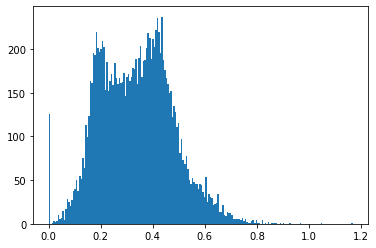

In [110]:
plt.hist(df_0D_clean.loc[:,'SubhaloRgas_0D'], bins=200)
plt.show()

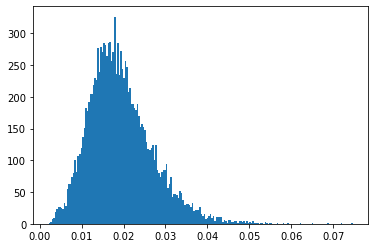

In [111]:
plt.hist(df_0D_clean.loc[:,'SubhaloRstar_0D'], bins=200)
plt.show()

df[(df.loc[:, 'SubhaloLogMstar']>8) & (df.loc[:, 'SubhaloFlag'] == True)]